In [1]:
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from sklearn.manifold import TSNE

from src.load_data import *
from src.graph_data import *
from src.utils import *
from src.scripts import *

['/Users/finnweikert/opt/anaconda3/envs/ADAproj/lib/python311.zip', '/Users/finnweikert/opt/anaconda3/envs/ADAproj/lib/python3.11', '/Users/finnweikert/opt/anaconda3/envs/ADAproj/lib/python3.11/lib-dynload', '', '/Users/finnweikert/opt/anaconda3/envs/ADAproj/lib/python3.11/site-packages', '/Users/finnweikert/Desktop/Ada', '/Users/finnweikert/Desktop/Ada']
---- WARNING: The following articles have a problem: ----
Badugi has no links (out-edges) listed.
Color_Graphics_Adapter has no links (out-edges) listed.
Directdebit has no category listed.
Directdebit has no links (out-edges) listed.
Donation has no category listed.
Donation has no links (out-edges) listed.
Douglas_DC-4 has no links (out-edges) listed.
Duchenne_muscular_dystrophy has no links (out-edges) listed.
Friend_Directdebit has no category listed.
Klinefelter%27s_syndrome has no links (out-edges) listed.
Local_community has no links (out-edges) listed.
Lone_Wolf_%28gamebooks%29 has no links (out-edges) listed.
Osteomalacia has

In [2]:
# new import list (add all needed imports here not)
import os
import pyarrow.feather as feather
from src.scripts.load_data import load_data
from src.scripts.convert_into_df import paths_to_df, articles_to_df
from src.scripts.path_processing import filter_finished_paths, filter_unfinished_paths, filter_duration
from src.scripts.backup_dfs import backup_dataframes
from src.utils.helpers import plot_path_length_distributions, plot_by_distance, plot_duration_histogram, plot_styled_bar_chart

In [2]:
#%pip install -r requirements.txt

# Part 0 : Data Handling 

## Load and Convert Data into Dataframes
 Here, we have rearranged the data making it easier to work with. We have split the data up into two data frames described as follows :  
 **Need to explain what each col stands for**


## Article DF
| Article | Category |linkTargets | Article_id | distances | plain_text | 
| ------- | ---------- | ------------ | ---------- | ---------- | ---------- |
| string | string | list[string] | string | dict[string, int] | string | 


## Path DF
| hashedIpAddress | timestamp   | durationInSec | identifier | full_path    | simplified_path | full_path_length | simplified_path_length | distance |  
|------------------|------------|---------------|------------|--------------|-----------------|------------------|-----------------------|----------|  
| string           | int        | int           | string     | list[string] | list[string]    | int              | int                   | int      |  

**Column Explanations**  
`hashedIpAdress`: identifies the computer from wich the game was played. We assume same IpAdress => same player.  
`timestamp`: game time stamp  
`durationInSec`: the time in seconds it took to play the path  
`identifier`: identifier for games that have the same start and target article pair  
`full_path`: path with all visited articles  
`simplified_path`: direct path excluding detour articles  
`distance`: the shortes possible distance from start to target article  



In [4]:
# If the data has not already been loaded
if not os.path.exists('Data/dataframes/article_dataframe.feather'):
    print('Loading data...')
    articles, categories, links, paths_finished, paths_unfinished, distances = load_data()
    print('Converting the data into dataframes...')
    # article dataframe
    article_df = articles_to_df(articles, categories, links, distances)
    # paths dataframe
    paths_df = paths_to_df(paths_finished, paths_unfinished, article_df)
    # save dataframes
    article_df.to_feather('Data/dataframes/article_dataframe.feather')
    paths_df.to_feather('Data/dataframes/paths.feather')
else:
    print('Data already converted into dataframes, load stored dataframes...')
    article_df = feather.read_feather('Data/dataframes/article_dataframe.feather')
    paths_df = feather.read_feather('Data/dataframes/paths.feather')

Data already converted into dataframes, load stored dataframes...


In [5]:
article_df

,article,category,linkTarget,distances,plain_text
0,Áedán_mac_Gabráin,[subject.History.British_History.British_Histo...,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...
1,Åland,"[subject.Countries, subject.Geography.European...","[20th_century, Baltic_Sea, Crimean_War, Curren...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÅland\n\n2007 Schools Wikiped...
2,Édouard_Manet,[subject.People.Artists],"[Absinthe, Beer, Claude_Monet, Diego_Velázquez...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉdouard Manet\n\n2007 Schools...
3,Éire,"[subject.Countries, subject.Geography.European...","[Canada, English_language, George_VI_of_the_Un...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉire\n\n2007 Schools Wikipedi...
4,Óengus_I_of_the_Picts,[subject.History.British_History.British_Histo...,"[Dál_Riata, Durham, England, Great_Britain, Ir...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÓengus I of the Picts\n\n2007...
...,...,...,...,...,...
4599,Zionism,"[subject.People.Political_People, subject.Reli...","[18th_century, 19th_century, Adolf_Hitler, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZionism\n\n2007 Schools Wikip...
4600,Zirconium,[subject.Science.Chemistry.Chemical_elements],"[Aluminium, Arabic_language, Australia, Bicycl...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZirconium\n\n2007 Schools Wik...
4601,Zoroaster,[subject.People.Religious_figures_and_leaders],"[18th_century, 9th_century, Afghanistan, Age_o...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZoroaster\n\n2007 Schools Wik...
4602,Zuid-Gelders,"[subject.Geography.European_Geography, subject...","[Brabantian, Dutch_language, East_Flemish, Hol...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZuid-Gelders\n\n2007 Schools ...


In [6]:
paths_df

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,distance,full_path_length,simplified_path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",3.0,8,8
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,True,None,14th_century,African_slave_trade,48,"[14th_century, Europe, Africa, Atlantic_slave_...","[14th_century, Europe, Africa, Atlantic_slave_...",3.0,4,4
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, Niger, Nigeria, British_Empire,...","[14th_century, Niger, Nigeria, British_Empire,...",3.0,7,7
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,True,None,14th_century,Greece,52,"[14th_century, Renaissance, Ancient_Greece, Gr...","[14th_century, Renaissance, Ancient_Greece, Gr...",2.0,3,3
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,True,None,14th_century,John_F._Kennedy,56,"[14th_century, Italy, Roman_Catholic_Church, H...","[14th_century, Italy, Roman_Catholic_Church, H...",3.0,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76188,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,NaN,False,restart,Franz_Kafka,Cholera,15039,"[Franz_Kafka, Tuberculosis, World_Health_Organ...","[Franz_Kafka, Tuberculosis, World_Health_Organ...",3.0,6,5
76189,232f992e57d43e8d,1389787697,6,Modern_history,NaN,False,restart,Modern_history,Hollandic,25796,[Modern_history],[Modern_history],3.0,0,0
76190,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,NaN,False,timeout,Computer_programming,The_Beatles,9818,"[Computer_programming, Linguistics, Culture, P...","[Computer_programming, Linguistics, Culture]",3.0,3,2
76191,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,NaN,False,timeout,Jamaica,Alan_Turing,20569,"[Jamaica, United_Kingdom, World_War_II, Battle...","[Jamaica, United_Kingdom, World_War_II, Battle...",3.0,3,3


# Part 1 : Processing and Analysis of Played Paths

The played path data is in subsequent parts used for article scoring, where the score needs to capture articles 'quality' for players in the game. Therefore, it is essential that prior path data pre-processing is performed.  

## 1.1 Outlier Handling

Since we will be interested in path length and time taken to compute article scores, we need to perform outlier filtering on these columns of our path data frame. This will be done on **finished** and **unfinished paths** separately.

#### Finished Path Filtering

1. **Downsampling to One Path per Player per Identifier**:
    - First we downsample the data so that each start-target article pair can only have been played by a player once (downsample to one `hashedIpAddress`, `identifier` pair). This ensures that we don't consider all the paths that have been learned by players through mulitple attemps.

2. **Downsampling Same Start-Target Pairs**:
    - By ensuring that the same start-target pair does not appear more than a specified number of times (we set to 5), we make sure that certain paths are not overrepresented. In fact, we have observed that while most start-target pairs are only present once, in some cases they have been played around 1000 times.

3. **Remove Paths with distance=0 (same start and target article)**:
    - We noticed that a few samples have distance 0, these also need to be removed.

4. **Outlier Removal with the IQR Method**:  
      
    **For Path Length**
    - The **IQR method** is applied to filter out paths based on **full path length**. The IQR is calculated for each distance group, and any paths outside the range of `[Q1 - multiplier * IQR, Q3 + multiplier * IQR]` are considered outliers and removed. The distance goup is the group af paths that have the same `distance` value i.e can reach their target in the same minimal number of clicks. We filter seperately for each distance group as, these groups will obviously have different statistics.

    **For Path Time**  
    - Since **duration** is relevant only for finished paths, the IQR method is applied to filter out paths based on their **duration**. Paths with durations greater than the calculated upper bound (`Q3 + 1.5 * IQR`) are removed, again seperately for each distance goup.


#### Unfinished Path Filtering

1. **Removing Unnecessary Failures**:
    - First we remove paths where the player did not actively fail the path (i.e., `failure_reason != 'timeout'`). Only paths where the player made an active decision to stop the path are considered. While not conservative, this is a first indicator that the user actually tried.

2. **Filtering Path Length Using the IQR Method**:
    - Similar to the finished paths, the IQR method is applied to filter out **unfinished paths** based on **full path length**. The upper bound for the full path length is determined by the IQR, and any paths that exceed this value are removed.

3. **Simplified Path Length Check**:
    - Additionally, the function ensures that the **simplified path length** is greater than or equal to the **distance**. This condition helps remove paths where the simplified path length is implausibly shorter than the actual distance.


Before calling the filtering function that do what is explained above, let's look at the data prior to filtering.  
First we consider the **Path Length** statistics.
The Very large max values indicates that outlier removal is deinetly required.

In [7]:
finished_paths = paths_df[paths_df['finished']]
unfinished_paths = paths_df[~paths_df['finished']]

print(f"Finished path length statistics:\n    {finished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")
print(f"Unfinished path length statistics:\n    {unfinished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")

Finished path length statistics:
           full_path_length  simplified_path_length
count      51318.000000            51318.000000
mean           5.356775                4.956117
std            3.775778                3.288758
min            0.000000                0.000000
25%            3.000000                3.000000
50%            5.000000                4.000000
75%            6.000000                6.000000
max          419.000000              404.000000

Unfinished path length statistics:
           full_path_length  simplified_path_length
count      24875.000000            24875.000000
mean           3.678915                3.160040
std            4.595089                3.942539
min            0.000000                0.000000
25%            1.000000                1.000000
50%            3.000000                2.000000
75%            5.000000                4.000000
max          191.000000              148.000000



And for the **duration** statistics. Again the very large max value indicates that outlier handling is needed.


In [8]:
print(f"Finished path duration statistics:\n    {finished_paths[['durationInSec']].describe()}\n")

Finished path duration statistics:
           durationInSec
count   51318.000000
mean      158.276199
std       360.841904
min         0.000000
25%        60.000000
50%       107.000000
75%       183.000000
max     35091.000000



In [9]:
length_filt_finished_paths = filter_finished_paths(finished_paths)
print("-"*50)
time_filt_finished_paths = filter_duration(finished_paths)
print("-"*50)
filt_unfinished_paths = filter_unfinished_paths(unfinished_paths)

In path length filtering a total of 10797 paths were removed from the finished paths, which represents 21.039% of the original finished data.  40521 paths remain.
--------------------------------------------------
In path duration filtering a total of 11233 paths were removed from the finished paths, which represents 26.120% of the original finished data.  40085 paths remain.
--------------------------------------------------
A total of 18254 paths were removed from the unfinished paths, which represents 73.383% of the original unfinished data.  6621 paths remain.


**storing can maybe removed in final version**

In [22]:
# store the filtered dataframes as feather files
length_filt_finished_paths.to_feather('Data/dataframes/length_filtered_finished_paths.feather')
time_filt_finished_paths.to_feather('Data/dataframes/time_filtered_finished_paths.feather')
filt_unfinished_paths.to_feather('Data/dataframes/unfinished_paths.feather')

## 1.2 Analysis of the path distributions

We will do so starting with the **finished paths**. where the goal is to get a histogram of the path lengths.

We will visualize histograms for:
 1. **Path length** distribution 
 2. **Path duration** distribution

Prior to filtering:


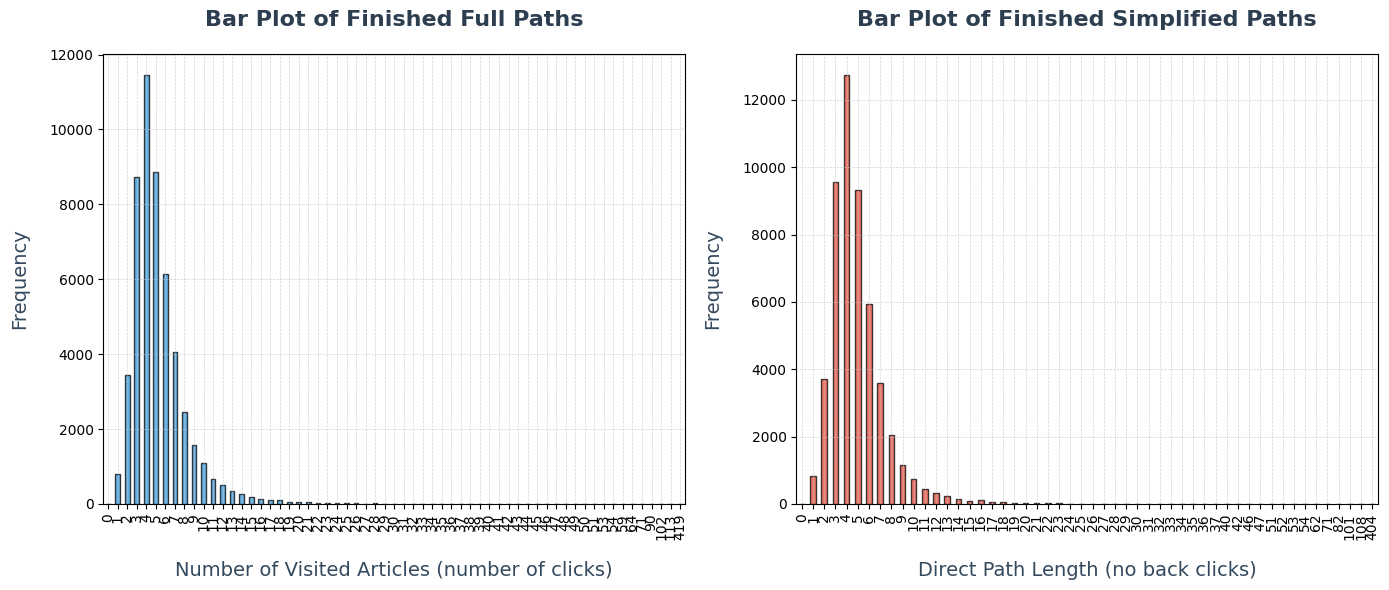

After filtering:


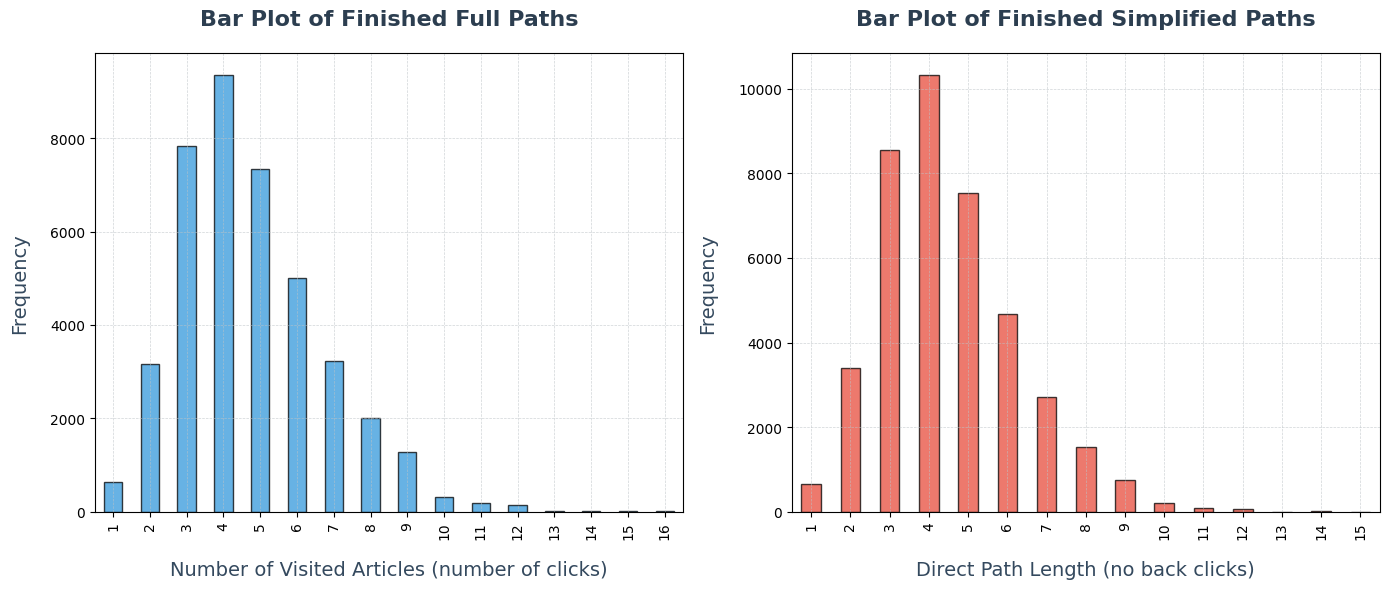

In [10]:
# Plot the histograms for full path and simpliefied path lengths prior to filtering
print("Prior to filtering:")
plot_path_length_distributions(finished_paths)

# And post filtering
print("After filtering:")
plot_path_length_distributions(length_filt_finished_paths)



This looks pretty good! While it may appear that the upper cutoff threshold is a bit large, this is simply due to these plots looking at the global path length distributions, while we filter for each distance group individually. And since these groups are distributed differently, we will keep some sample with longer paths.  
Below the distance group distribtions are plotted. 

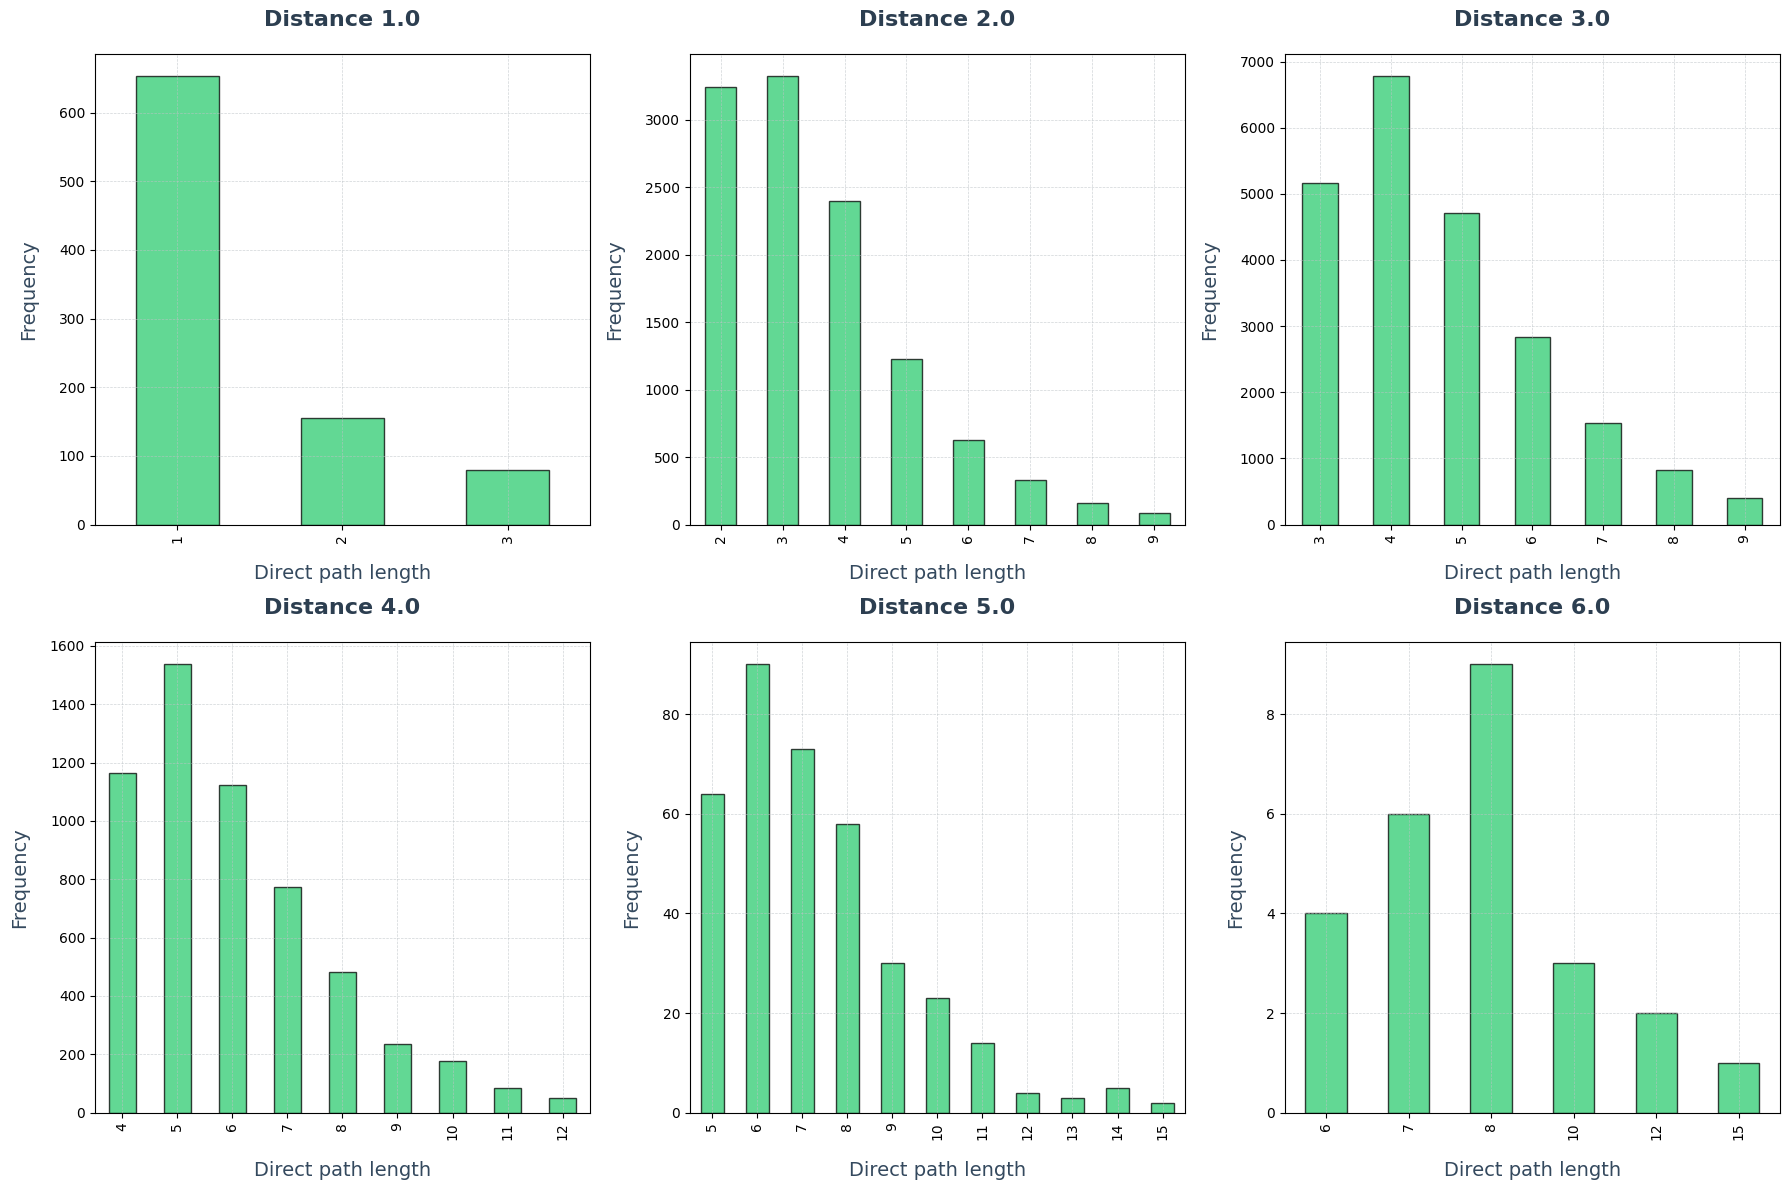

In [11]:
plot_by_distance(length_filt_finished_paths, 'simplified_path_length', x_label='Direct path length')

And now for the duration filtered finished paths...

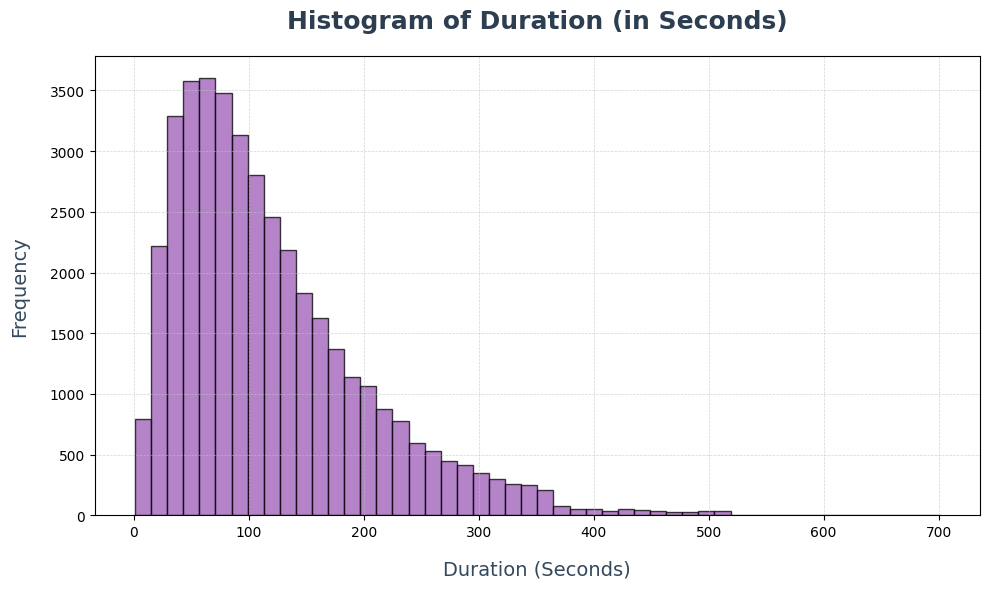

In [12]:
plot_duration_histogram(time_filt_finished_paths, bins=50)

Again the distribution has a long tail which is due to the seperate IQR filtering for the different distance groups. The plots below show this.

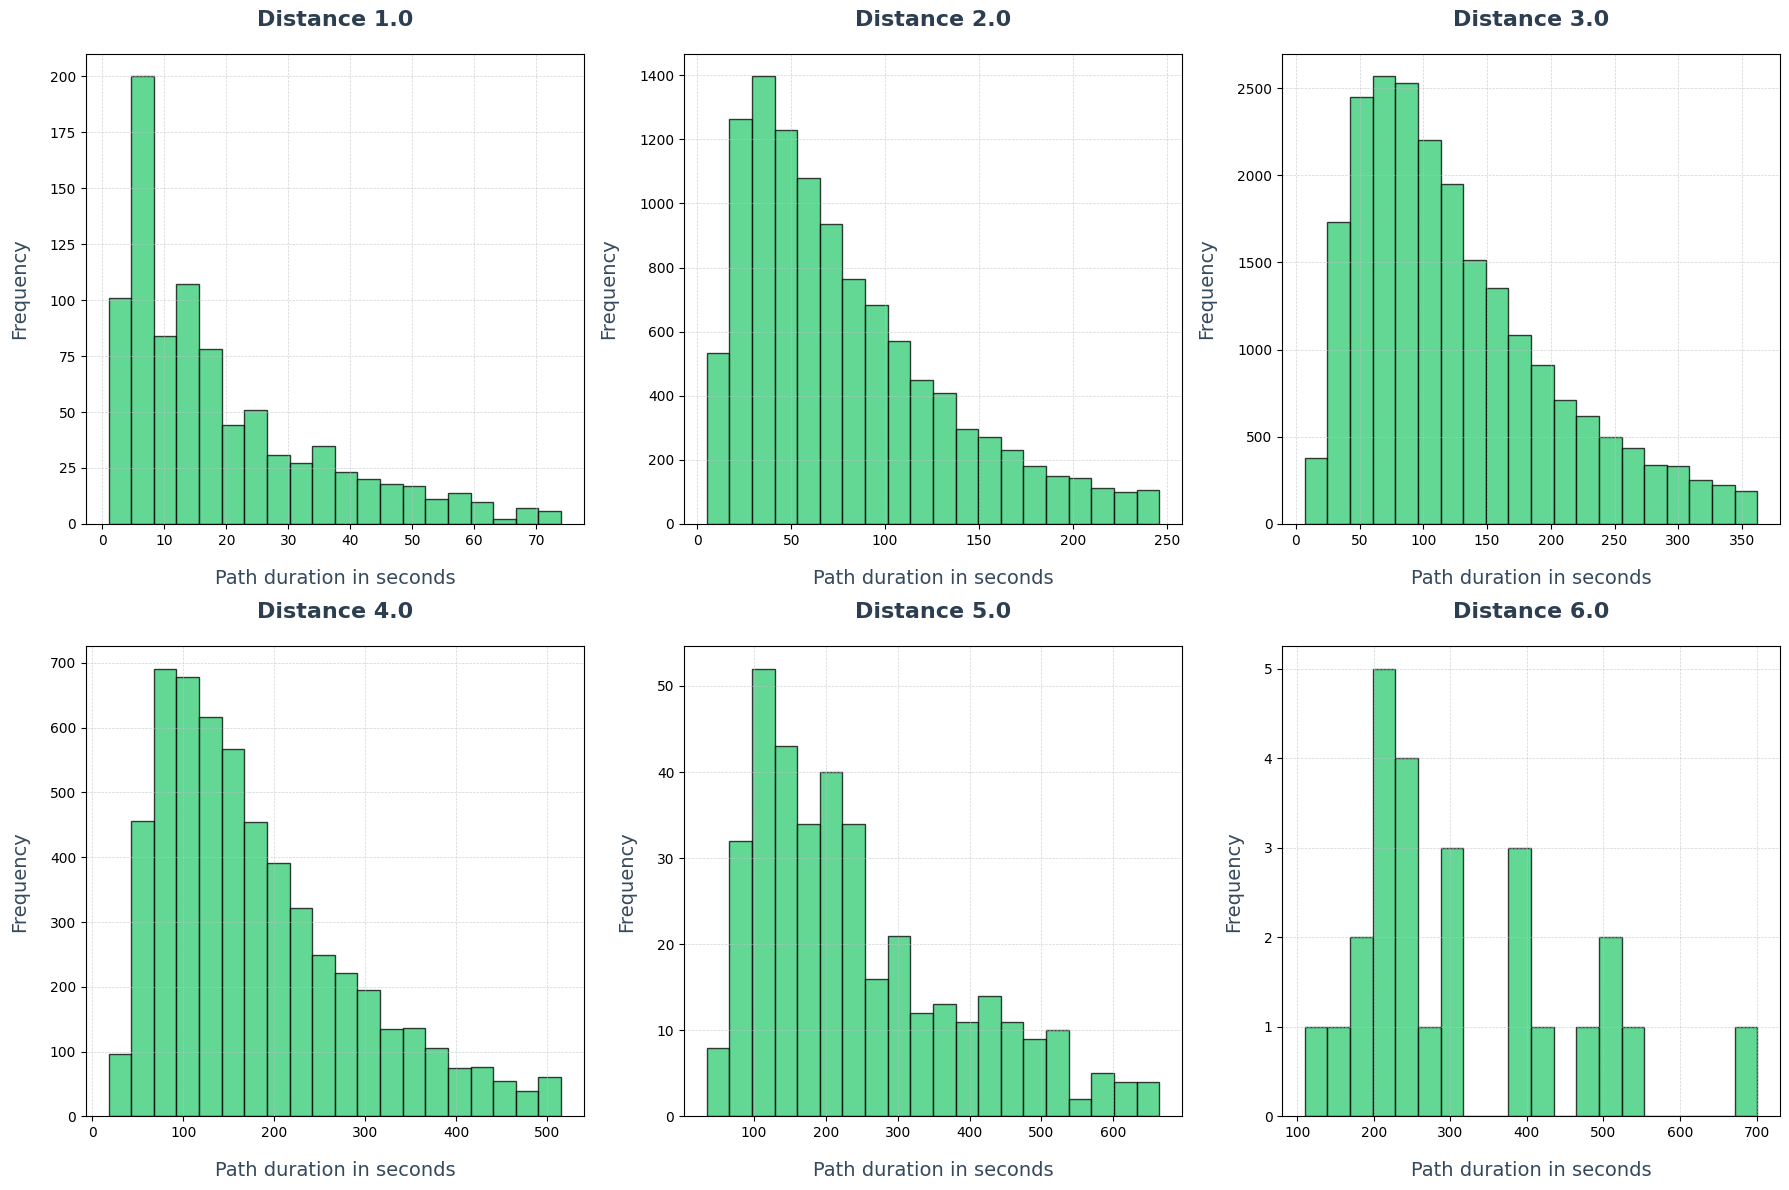

In [13]:
plot_by_distance(time_filt_finished_paths, 'durationInSec', x_label='Path duration in seconds', plot_type='hist', bins=20)

Now let's also have a look at the **unfinished paths**. We only consider the path length distribution, as in unfishished paths are not used for duration based article scoring.

Prior to filtering:


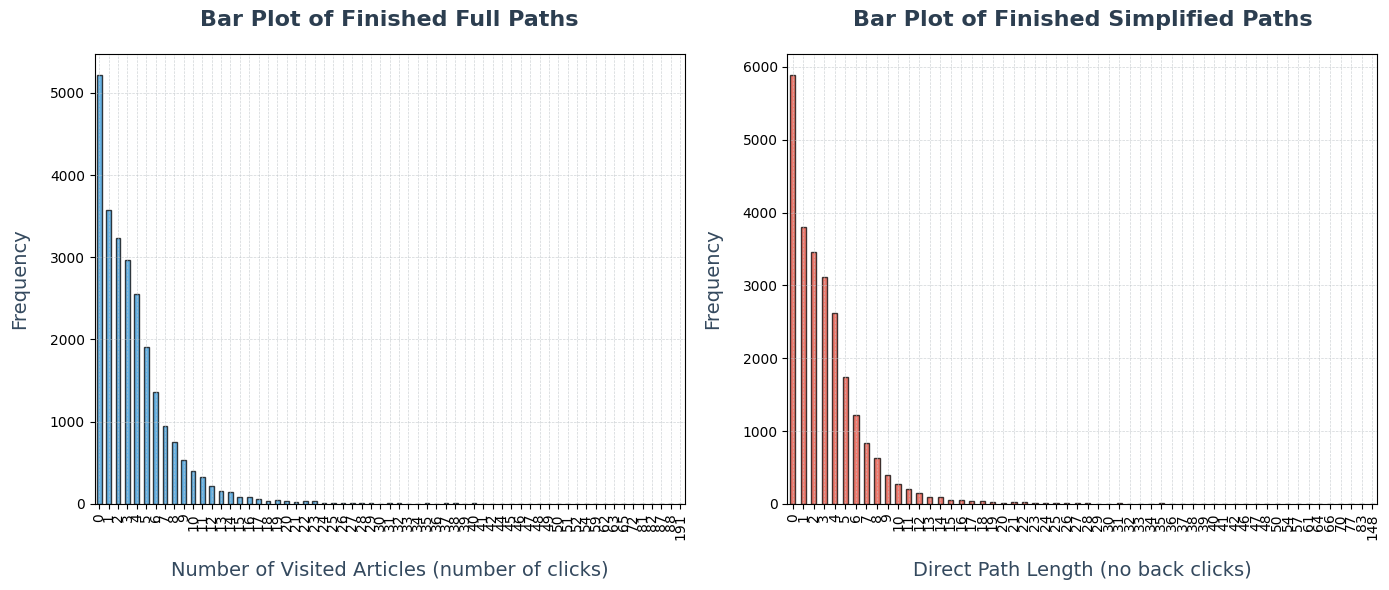

After filtering:


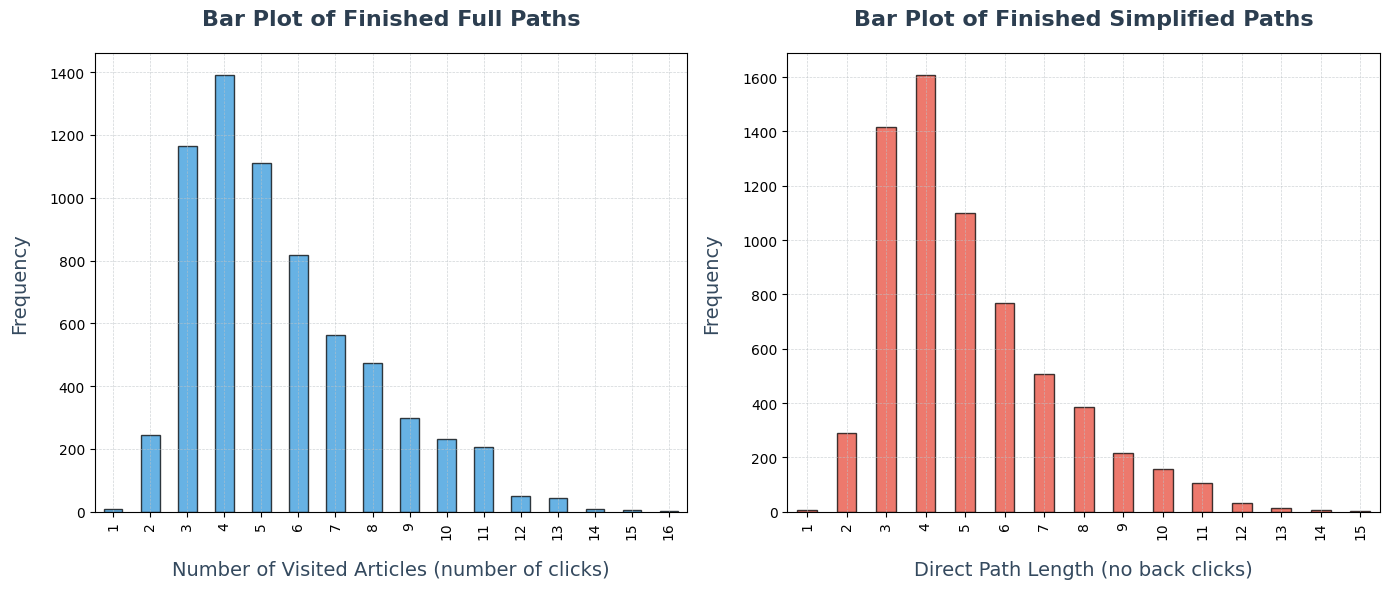

In [14]:
# Plot the histograms for full path and simpliefied path lengths prior to filtering
print("Prior to filtering:")
plot_path_length_distributions(unfinished_paths)

# And post filtering
print("After filtering:")
plot_path_length_distributions(filt_unfinished_paths)

 Again the histogram suggests that the filtering is reasonable.

In [ ]:
#### MAYBE IF WE NEED THIS LATER (OTHERWISE DELETE)

# finally we merge the finished and unfinished data frames
#filtered_paths = pd.concat([filtered_finished_paths, filtered_unfinished_paths]).drop('length_minus_distance', axis=1)

#filtered_paths.to_feather('Data/dataframes/filtered_paths.feather')

For comparison let's also have a look at the distribution of the shortest possible distance distribution and its statistic. 

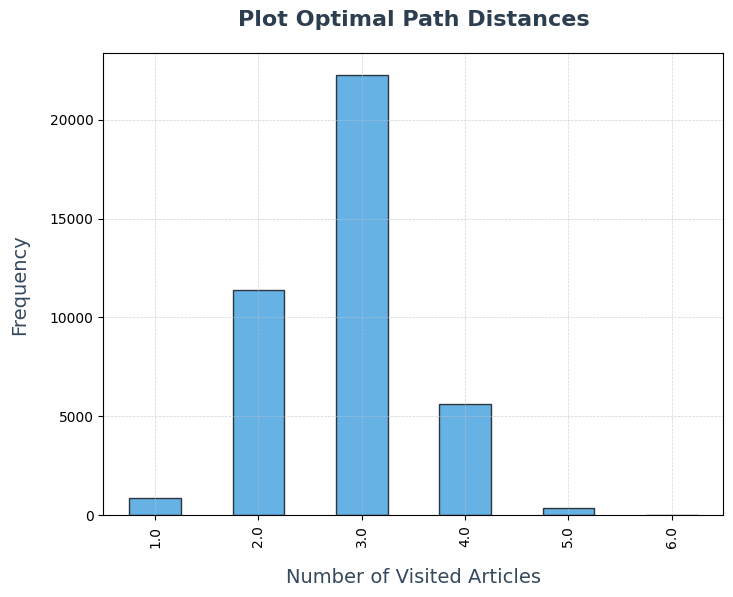

In [15]:
# plot the distribution of the shortest possible path lengths
distance_counts = length_filt_finished_paths['distance'].value_counts().sort_index()
plot_styled_bar_chart(distance_counts, title="Plot Optimal Path Distances", x_label="Number of Visited Articles", y_label="Frequency")

**Interesting observatin**

We just obversed that pretty much any article is reachable within at most 6 clicks (3 exeption with distance 7). This is interesting when we thik of the six degrees of separation idea...

## 1.3 OTHER STUFF TO ADD in this section:

- Also create a proof of concept smaller dataframe and as back up using the start-target pairs for which there are so many samples

- Make this comment that in the time filtering we found that players where racing each other achieving crazy fast times...

### Backup Dataframes for scoring

During the data filtering process, we noticed that while most start-target article pairs were played only a few times, there were some pairs that appeared more than 1000 times. To prevent these highly frequent pairs from disproportionately influencing article scores, we set a threshold (5) to downsample these pairs, in the filtering explained above.

However, we also want to use the data for the heavily repeated pairs to compute backup article scores. These scores won't reflect the global popularity or quality of an article, but rather its performance within a subset of the data. Specifically, the games where the pairings have been played very frequently. We expect these backup scores to be more robust for cases where the global scores might not perform well, serving as a proof of concept for when the global article scores fall short.

- `top_4_paths`: start-target pairs with more than 1000 samples.
- `top_10_paths`: start-target pairs with more than 100 samples.

In [21]:
top4_paths, top10_paths = backup_dataframes(paths_df)

# filterering for backup top4 dataframe
print("Filtering for top 4 start-target pairs:")
finished_top4_paths = top4_paths[top4_paths['finished']]
unfinished_top4_paths = top4_paths[~top4_paths['finished']]
# a very large pair threshold is used to include all paths
path_filt_top4 = filter_finished_paths(finished_top4_paths, pair_threshold=10000)
time_filt_top4 = filter_duration(finished_top4_paths, pair_threshold=10000)
filt_unfinished_top4 = filter_unfinished_paths(unfinished_top4_paths)
print("-"*50)

print("Filtering for top 10 start-target pairs:")
# filterering for backup top10 dataframe
finished_top10_paths = top10_paths[top10_paths['finished']]
unfinished_top10_paths = top10_paths[~top10_paths['finished']]
# a very large pair threshold is used to include all paths
path_filt_top10 = filter_finished_paths(finished_top10_paths, pair_threshold=10000)
time_filt_top10 = filter_duration(finished_top10_paths, pair_threshold=10000)
filt_unfinished_top10 = filter_unfinished_paths(unfinished_top10_paths)

Filtering for top 4 start-target pairs:
In path length filtering a total of 501 paths were removed from the finished paths, which represents 13.802% of the original finished data.  3129 paths remain.
In path duration filtering a total of 545 paths were removed from the finished paths, which represents 16.525% of the original finished data.  3085 paths remain.
A total of 2546 paths were removed from the unfinished paths, which represents 71.779% of the original unfinished data.  1001 paths remain.
--------------------------------------------------
Filtering for top 10 start-target pairs:
In path length filtering a total of 735 paths were removed from the finished paths, which represents 17.053% of the original finished data.  3575 paths remain.
In path duration filtering a total of 785 paths were removed from the finished paths, which represents 20.872% of the original finished data.  3525 paths remain.
A total of 2746 paths were removed from the unfinished paths, which represents 72.20

In [23]:
# store the filtered dataframes as feather files
path_filt_top4.to_feather('Data/dataframes/path_filtered_top4_paths.feather')
time_filt_top4.to_feather('Data/dataframes/time_filtered_top4_paths.feather')
filt_unfinished_top4.to_feather('Data/dataframes/unfinished_top4_paths.feather')

path_filt_top10.to_feather('Data/dataframes/path_filtered_top10_paths.feather')
time_filt_top10.to_feather('Data/dataframes/time_filtered_top10_paths.feather')
filt_unfinished_top10.to_feather('Data/dataframes/unfinished_top10_paths.feather')

# Part 2: Article Scoring

Bellow we explain different scores that we cam up with to quantize artilce "goodness" in the game.

***Prioritizing Scores Based on Minimal Clicks*** 

### **Difference Between Played Path Length and Optimal Distance**  
- **Optimal Distance**: The shortest possible distance from the start to the target article.  
- **Played Path Length**: The actual number of clicks (or visited articles - 1). This is represented in the dataset as `simplified_path_length`.  
- Why use `simplified_path_length` instead of `full_path_length`?  
  Simplified paths eliminate detours, thus only the articles relevant in finishing the path are taken into account.

We define the **Path Score** for a completed path as:  
$$
\mathbf{Path\ Score} = \frac{\text{Optimal\ Distance}}{\text{Simplified\ Path\ Length}}
$$  

This score ranges from 0 to 1, where 1 indicates the closest adherence to the optimal path. We refer to this score as the **path weight**, representing the ratio of actual path length to optimal distance.

#### **Article Scoring Based on Path Weights**  
After computing path weights for all completed paths, we use them to derive article scores using two approaches:

1. **Weighted Average**  
   Compute the average path weight for each article across all paths it appears in:  
   $$
   \mathbf{Article\ Score} = \frac{\sum_{i=1}^n w_i}{n}
   $$  
   where  $w_1, w_2, \dots, w_n$ are the path weights, and  $n$ is the number of paths the article appears in.  
   - This score is about article quality over quantity.
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.  
   - **Function**: `calculate_avg_article_weights(df, count_cutoff=30, scaling=None)`  

2. **Sum of Centered Weights**  
   - **Centering**: First, compute the mean article weight across all paths:  
     $$
     \text{Mean\ Article\ Weight} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{weight} \times \text{num\_artcicles\_in\_path}_i)}{\sum_{i=1}^N \text{num\_artcicles\_in\_path}_i}
     $$  
     where $N$ is the total number of paths (or a downsampled subset), and $\text{num\_artcicles\_in\_path}_i$ the number of articles in simplified path $i$ (without start and target article).

   - **Centered Weights**:  
     $$
     \mathbf{Centered\ Weight} = \mathbf{Path\ Score} - \text{Mean\ Article\ Weight}
     $$  
     Why center using article weight and not path weight? Because in the end, we are interested in computing article weights, and since paths don't have the same number of articles, the average path weight is not the same as the average article weight.

   - Compute the article score by summing all centered weights for the paths the article appears in:  
     $$
     \mathbf{Article\ Score} = \sum_{i=1}^n cw_i
     $$  
     where $cw_1, cw_2, \dots, cw_n$ are the centered weights.  
   - This score balances quality and usefulness within the game.  
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.  
   - **Function**: `calculate_sum_article_cweights(df, count_cutoff=30, scaling=None)`

---

## Scores Based on Article Appearance in Detours  

### **Detour Ratio**  
- Detours occur when articles are backtracked (i.e don't appear in simplified paths).  
- For each article  $i$, the **Detour Ratio** is:  
  $$
  \mathbf{DetourRatio_i} = \frac{\text{detour\_count}_i}{\text{total\_appearances}_i},
  $$  

  where the $\text{detour\_count}_i$ and $\text{total\_appearances}_i$ are the number of appearance in detours and total number of apperances for article $i$ respectively.  
  This score caputres information that the is not present in the weighted_abvg or sum scores, and is thus well suited to make a composite score.
- Only articles with a minimum total appearance threshold are considered.  
- **Function**: `calculate_detour_ratios(df, count_cutoff=30, scaling=None)`  

---

## Scores Based on Article Presence in Unfinished Paths  

### **Unfinished Ratio**  
- Measures how frequently an article appears in incomplete paths.  
- For each article $i$, the **Unfinished Ratio** is:  
  $$
  \mathbf{UnfinishedRatio_i} = \frac{\text{unfinished\_count}_i}{\text{total\_appearances}_i}
  $$  
- Again, articles must meet a minimum appearance threshold for meaningful scores.  
- **Function**: `calculate_unfinished_ratios(df, count_cutoff=30, scaling=None)`  

**========================================================================================================================================**

***Now Consider Scores That Reward Finishing the Game as Fast as Possible***

### **Weighted Average of Article Speed**  
We first compute **path speed**, defined as the time taken to complete the path (from `durationInSec`) divided by `full_path_length`. Similar to the weighted average of path weights, we can compute the average speed for each article. This involves extracting all $n$ paths an article appears in and calculating the average of the associated path speeds $s_1, s_2, \dots, s_n$:  
$$
\mathbf{Article\ Speed} = \frac{\sum_{i=1}^n s_i}{n}
$$  

Where $s_1, s_2, \dots, s_n$ are the path speeds, and $n$ is the number of paths containing the article.  

- Only articles with a minimum total appearance threshold are included for meaningful scores.  
- **Function**: `calc_avg_article_speed(df, count_cutoff=30, scaling=None)`  

---

### **Sum of Centered Article Speed**  
This approach mirrors the **sum of centered weights** but uses **path speed** instead of path weight.  

1. **Centering**: Compute the mean path speed across all paths:  
   $$
   \text{Mean\ Path\ Speed} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{speed} \times \text{full\_path\_length}_i)}{\sum_{i=1}^N \text{full\_path\_length}_i}
   $$  
   where $N$ is the total number of paths (or a downsampled subset).  

2. **Centered Speeds**:  
   $$
   \mathbf{Centered\ Speed} = \mathbf{Path\ Speed} - \text{Mean\ Path\ Speed}
   $$  

3. Compute the article score by summing all centered speeds for the paths the article appears in:  
   $$
   \mathbf{Article\ Score} = \sum_{i=1}^n cs_i
   $$  
   where $cs_1, cs_2, \dots, cs_n$ are the centered speeds, and $n$ is the number of paths the article appears in.  

- This score provides a balance between high speed and frequency of appearances. 
- **Function**: `calc_sum_article_cspeed(df, count_cutoff=30, scaling=None)`  

---  
***Imporant note about the scaling***  
The functions are all coded in a way that when scaling is applied to the scores, large values always are better. So for example, even if the ratio of unfinished paths should be as small as possible, the sacled score column, is flipped, so that larger means better. This way when different scores are combined in a composite score, bigger is also always better.

---  

In [1]:
# temp cell so i don't have to rerun everything
from src.utils.score_utils import *
from src.scripts.scores import compute_scores_df

import pandas as pd
import numpy as np
from pyarrow.feather import read_feather
import seaborn as sns
from src.utils.helpers import plot_scaled_score_correlations, perform_pca_and_plot

In [2]:
# temp cell so i don't need to run everything all the time
length_filtered_finished_paths = read_feather('Data/dataframes/length_filtered_finished_paths.feather')
time_filtered_finished_paths = read_feather('Data/dataframes/time_filtered_finished_paths.feather')
unfinished_paths = read_feather('Data/dataframes/unfinished_paths.feather')

# also the backup dataframes
path_filtered_top4_paths = read_feather('Data/dataframes/path_filtered_top4_paths.feather')
time_filtered_top4_paths = read_feather('Data/dataframes/time_filtered_top4_paths.feather')
unfinished_top4_paths = read_feather('Data/dataframes/unfinished_top4_paths.feather')

path_filtered_top10_paths = read_feather('Data/dataframes/path_filtered_top10_paths.feather')
time_filtered_top10_paths = read_feather('Data/dataframes/time_filtered_top10_paths.feather')
unfinished_top10_paths = read_feather('Data/dataframes/unfinished_top10_paths.feather')

Compute the scores for the filtered data sets

In [6]:
# This can take over a minute to run
scores_df = compute_scores_df(length_filtered_finished_paths, 
                              pd.concat([length_filtered_finished_paths, unfinished_paths]),
                              time_filtered_finished_paths, 
                              count_cutoff=30,
                              scaling='standard')

click_scores_df = scores_df.iloc[:, :-4]
speed_scores_df = scores_df.iloc[:, -4:]

Calculating click related scores...
Ratio of unfinished over finished paths: 0.14044800814560265
Calculating speed related scores...
Number of unique articles: 782


...And the back up data sets

In [3]:
top_4_scores_df = compute_scores_df(path_filtered_top4_paths,
                                    pd.concat([path_filtered_top4_paths, unfinished_top4_paths]),
                                    time_filtered_top4_paths,
                                    count_cutoff=50,
                                    scaling='standard')

Calculating click related scores...
Ratio of unfinished over finished paths: 0.24237288135593216
Calculating speed related scores...
Number of unique articles: 65


In [7]:
top_10_scores_df = compute_scores_df(path_filtered_top10_paths,
                                    pd.concat([path_filtered_top10_paths, unfinished_top10_paths]),
                                    time_filtered_top10_paths,
                                    count_cutoff=50,
                                    scaling='standard')

Calculating click related scores...
Ratio of unfinished over finished paths: 0.22819516407599305
Calculating speed related scores...
Number of unique articles: 75


## 2.1 Score anaylsis

### Check how the scores are correlated
If we want to define reasonable composite scores we should do some anaylsis on the relation between the scores.

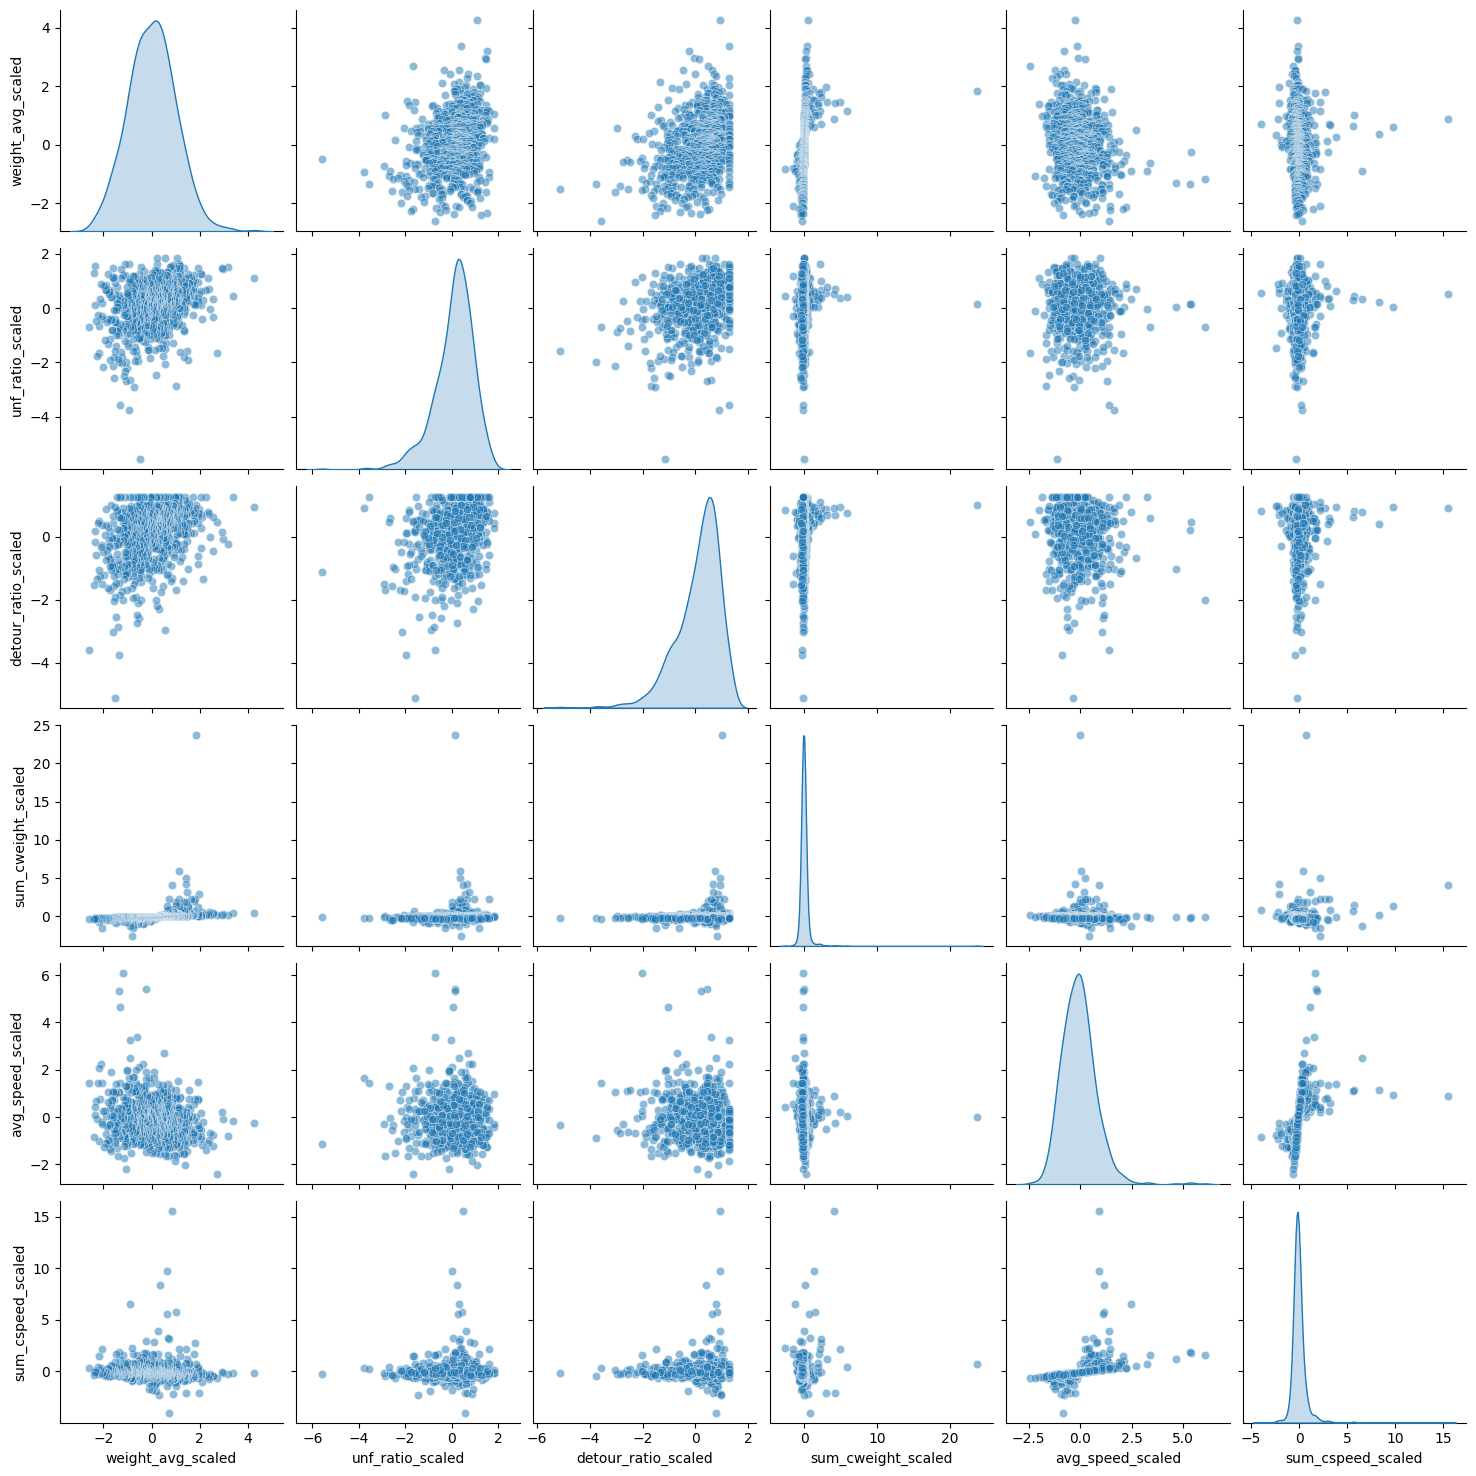

In [8]:
plot_scaled_score_correlations(scores_df)

**Comment (to redo later)**

In the sum of centered weight and speed scores, there are clear outliers, this is not really a surprise as article that appear a lot more often, can have very large/small values in these scores. Maybe these extreme values should be removed for ML tasks.

There does not appear to be any clear correlation, which is a bit surprising, but also indicates that the different scores are not redundant

## Definitng a meaningfull composite score

We would now like to combine some of the scores as they capture different aspects of the data. 
the scores that make sense to combine (after scaling) are:
- `weighted_avg`, `detour_ratio`, and `unfinished_ratio`
- `weighted_avg` and `detour_ratio`
- `sum_cweights`, `detour_ratio`, and `unfinished_ratio`
- `sum_cweights` and `detour_ratio`

Ideally, we would do so using a data driven approach. (**refine text**)

- First evaluate if PCA can be used to combine the scores
    by only considering the first principle component (PC1), we can potentially, combine mulitple scores. However, this only makes sense if the PC1 captures a large portion of the variance.
- Weighted Sum: combine the scores giving the a weight.


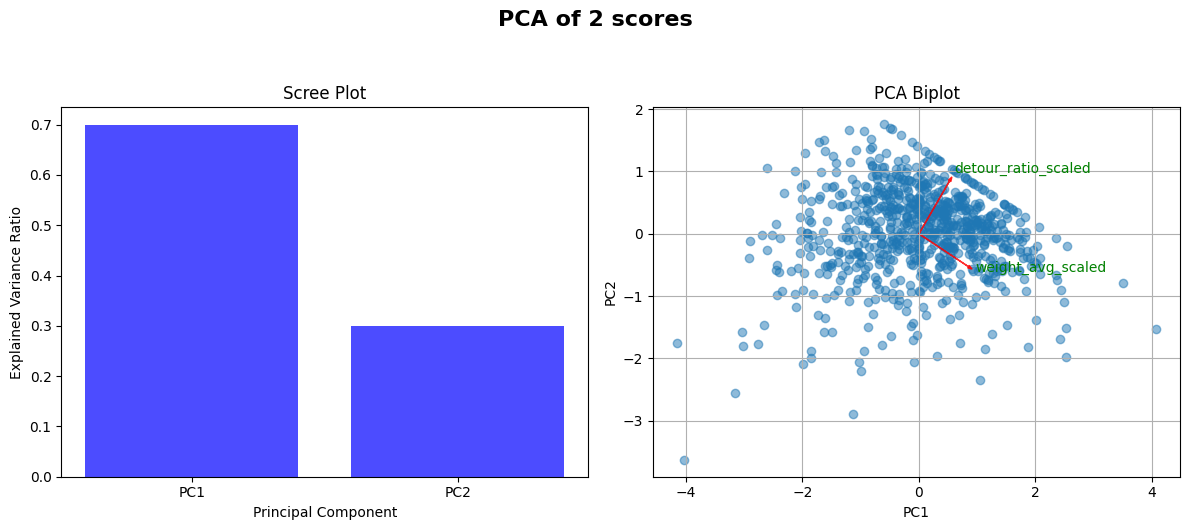

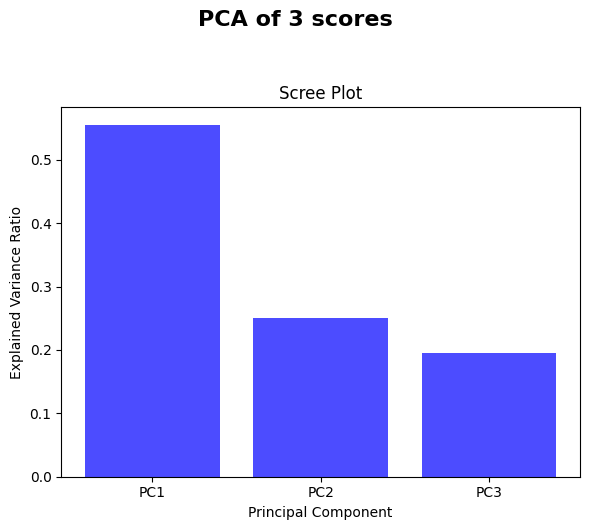

In [11]:
pca2, pca_components2 = perform_pca_and_plot(scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled'], biplot=True, title='PCA of 2 scores')
pca3, pca_components3 = perform_pca_and_plot(scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled', 'unf_ratio_scaled'], title='PCA of 3 scores', biplot=False)

In [15]:
pc1 = pca_components2[:, 0]

**Comment**

A rule of thumb is that the first principle component should capture at least 70% of the variance, if we want to use it for our composite scores. In both cases, it is below that, so it is probably not ideal as to much information would be lost in such a dimensionality reduction. but the combined score of only 2 metrics is close so we also consider it...

## Alternative: weighted sum of the scores.

While we have tried an other The Idea is that the larger the variance the more important the score's contribution should be to the composite.
Example with 3 scores:

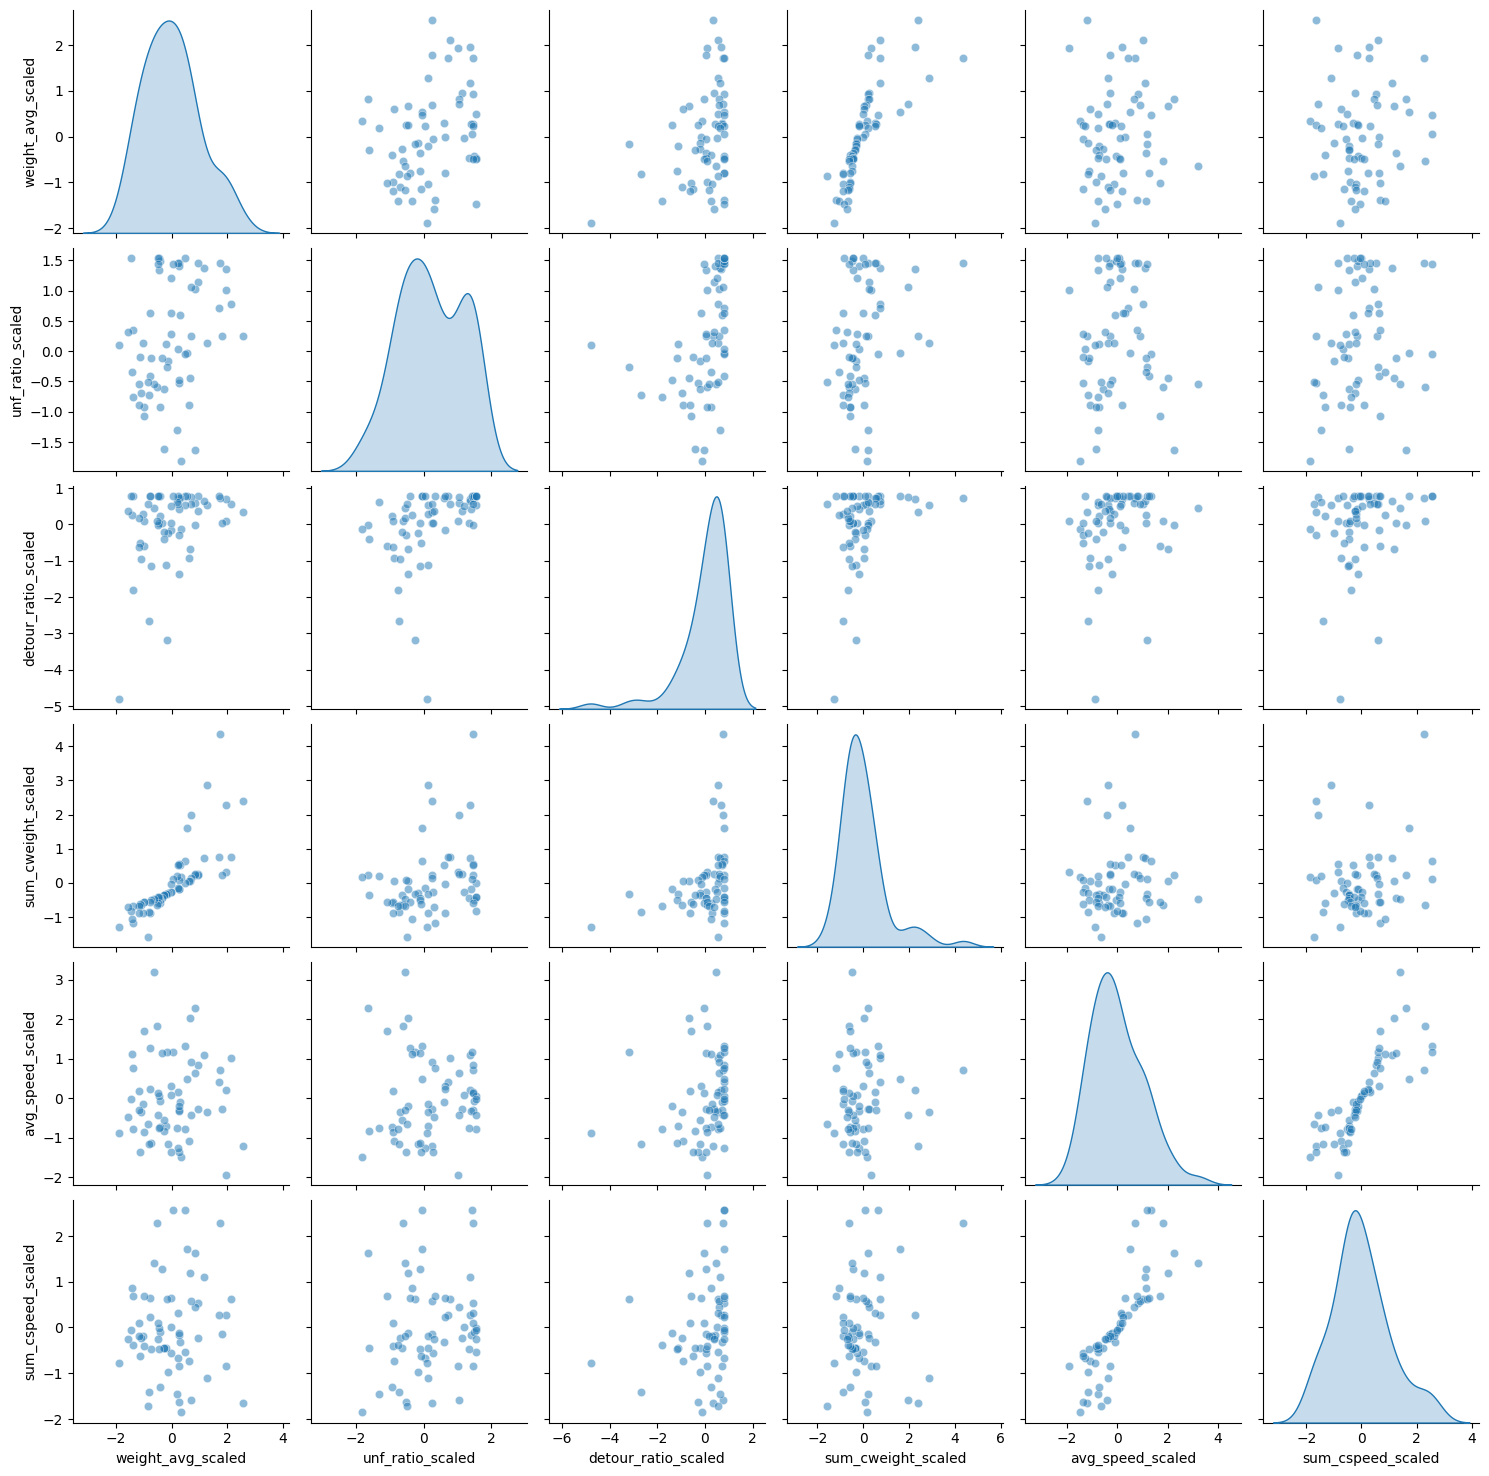

In [ ]:
# check if there are any NaN values in the dataframes
plot_scaled_score_correlations(top_4_scores_df)

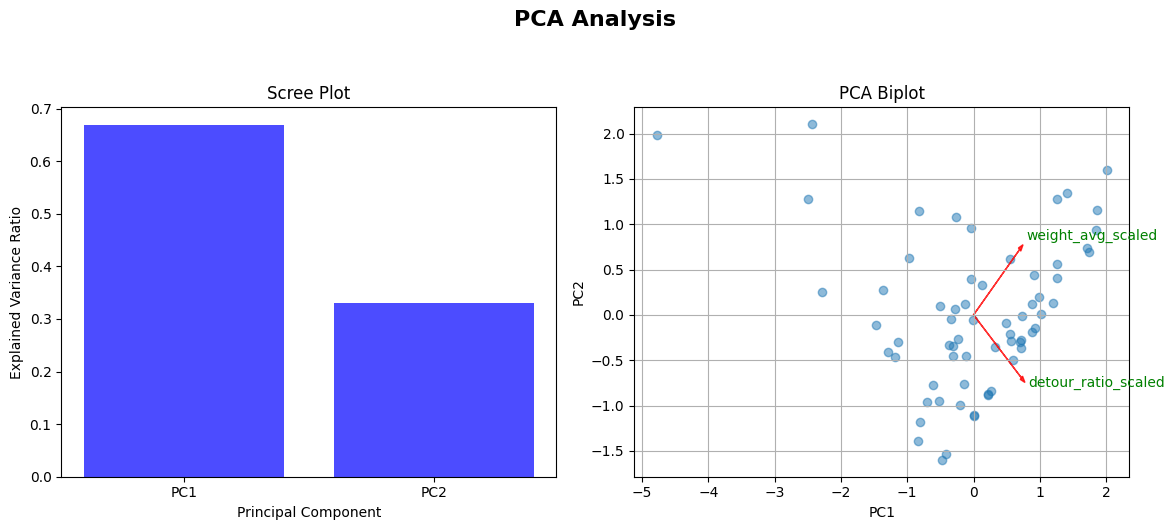

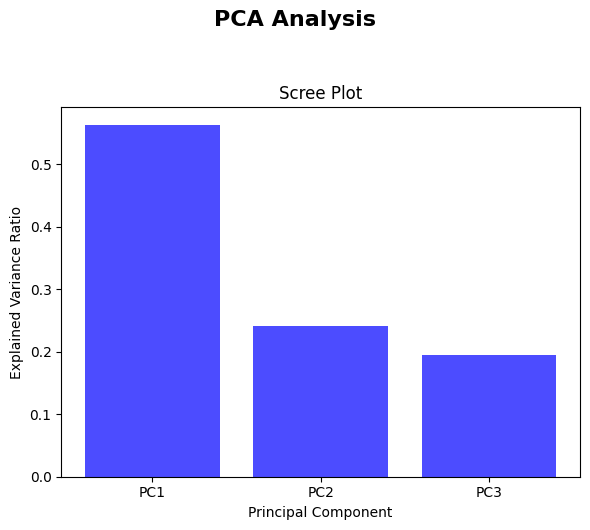

(PCA(n_components=3),
 array([[ 1.68197358,  1.93988001, -0.08718171],
        [ 1.83889879,  1.30147282,  0.16474047],
        [ 2.13830609,  0.87426484,  0.51111247],
        [ 1.56417507,  1.24621322,  0.63083751],
        [ 1.0442092 ,  1.45432519,  0.0807356 ],
        [ 2.08250057,  0.63155248,  0.53938553],
        [ 1.72230259,  0.888555  , -0.05114979],
        [ 1.01390199,  0.86211498, -0.34326586],
        [ 1.66641638,  0.24979238,  0.52247547],
        [ 1.24125167,  0.27176215,  0.51845234],
        [ 1.66208929, -0.03943409,  0.4802565 ],
        [-0.50843834,  1.41587075, -1.35204013],
        [ 1.25672868,  0.11613536,  0.28472187],
        [ 1.30407695, -0.05025939,  0.20052953],
        [ 0.76825405,  0.32825173, -0.30514018],
        [-0.41151461,  1.08661993, -0.03076988],
        [-0.825798  ,  1.31115022, -0.20349238],
        [ 0.66856896,  0.21833193, -0.66696985],
        [ 1.30505604, -0.33356677,  0.68623509],
        [ 0.6318274 ,  0.17903423, -0.67829833]

In [ ]:
_, _ = perform_pca_and_plot(top_4_scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled'], biplot=True)
_, _ = perform_pca_and_plot(top_4_scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled', 'unf_ratio_scaled', ], biplot=False)

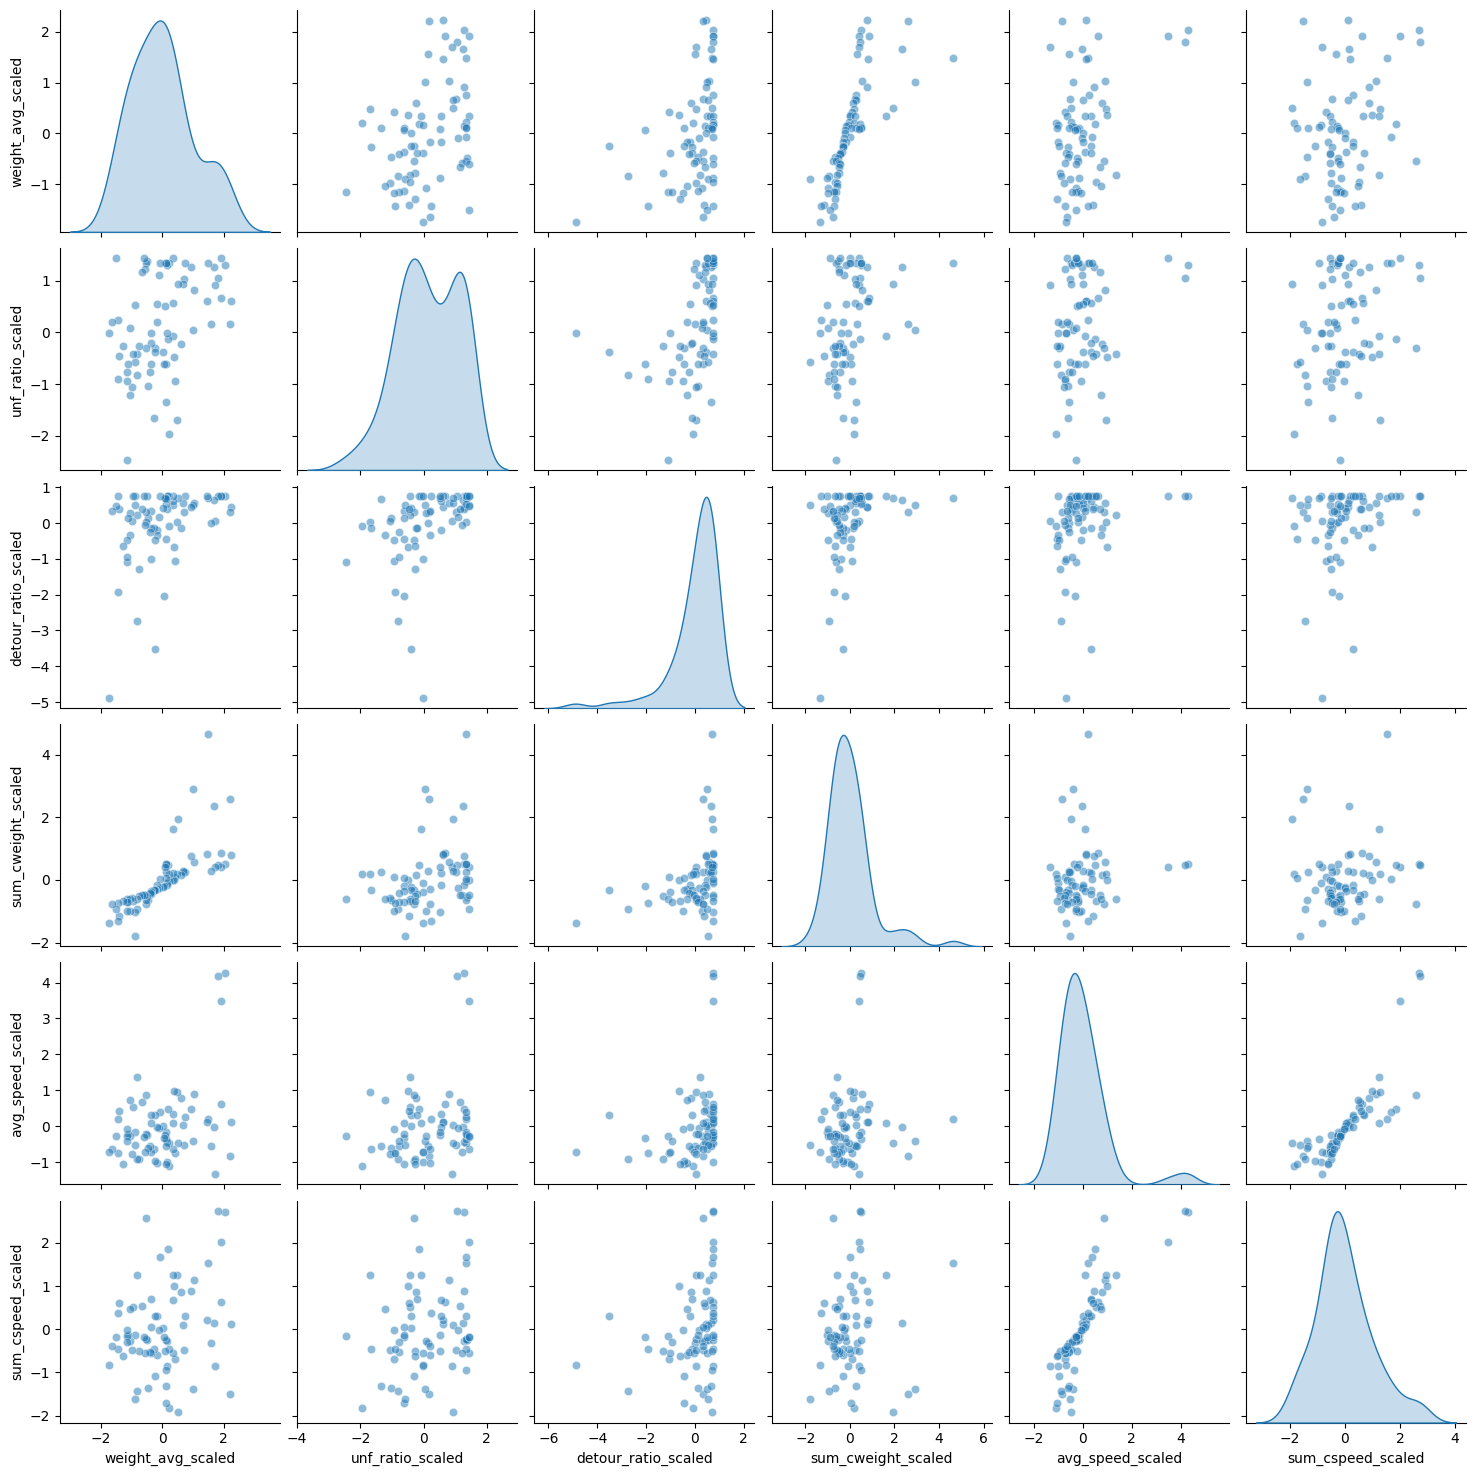

In [7]:
plot_scaled_score_correlations(top_10_scores_df)

.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  


# Part 3 Analysis of Article Data (qqn d'autre peut repasser sur ca svp)

In this section, we analyse key article attributes, including categories, hyperlinks and content characteristics. This will help us understand the distribution and variety within the data, providing a clearer picture of each article's features which will be useful later on.

In [27]:
print(f"In total there are {article_df.shape[0]} articles.")

In total there are 4604 articles.


### Most common categories of articles

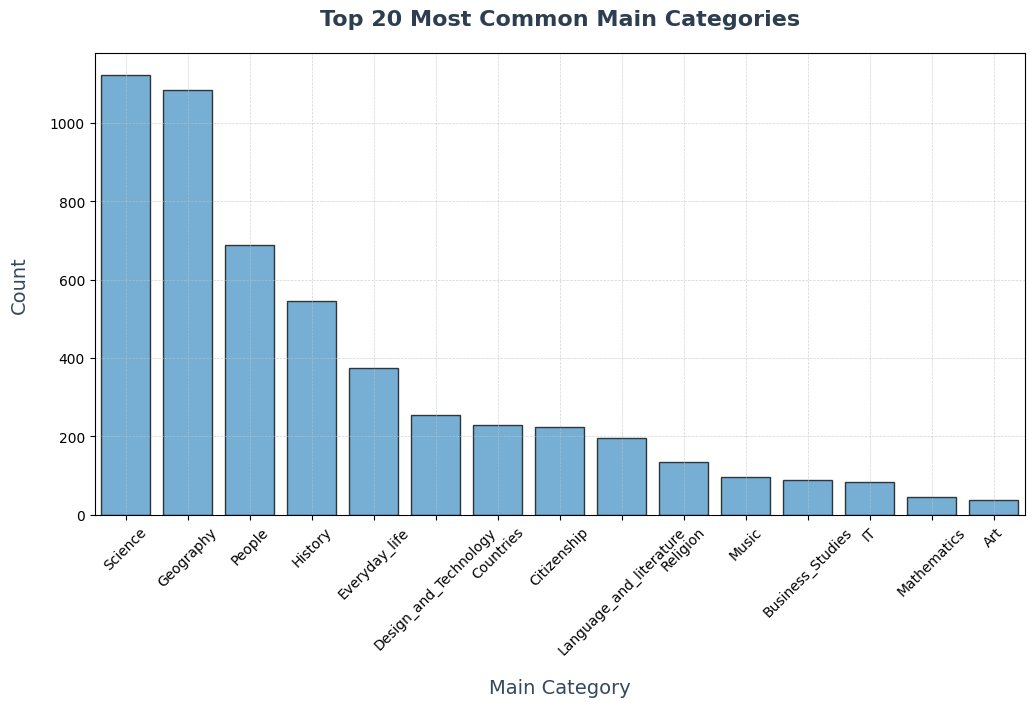

In [28]:
categories_exploded = article_df.explode('category')
categories_exploded['main_category'] = categories_exploded['category'].str.split('.').str[1]

# Here, we count the frequency of each main category
main_category_counts = categories_exploded['main_category'].value_counts()
top_20_main_categories = main_category_counts.head(20)


fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_20_main_categories.index, y=top_20_main_categories.values, ax=ax, color='#3498db', edgecolor='black', alpha=0.75)

ax.set_title("Top 20 Most Common Main Categories", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Main Category", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Count", fontsize=14, color='#34495E', labelpad=15)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
ax.tick_params(axis='x', rotation=45)

plt.show()

**Comment:**  From the above bar plot, we can observe the distribution of different categories in our dataset. Geography and science are the two most prominent categories, with a large number of articles, while art and mathematics are represented by relatively fewer articles. For further analysis it might be interesting to see what categories are the most present in the best ranked articles.

### Incoming hyperlinks

Here, we focus on the attribute "incoming hyperlinks", which represents how easily an article can be reached from other articles in the network that have a one-way hyperlink to it.

First, we look at the 10 articles with the most incoming hyperlinks :

Top 10 Most Linked-To Articles:
linkTarget
United_States       1551
United_Kingdom       972
France               959
Europe               933
England              751
World_War_II         751
Germany              743
India                611
English_language     598
London               587
Name: count, dtype: int64


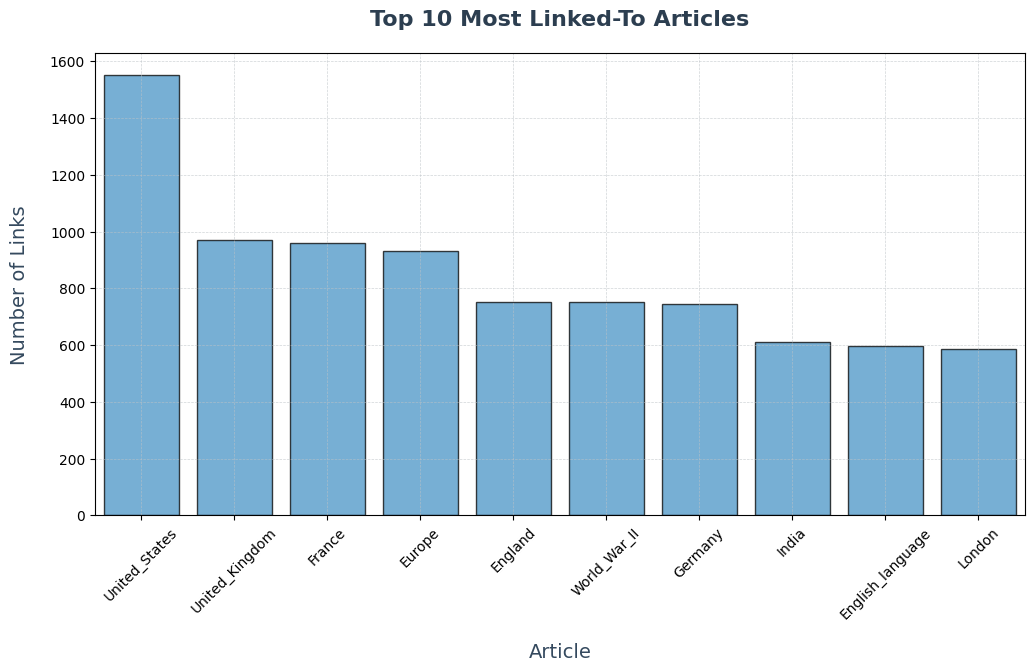

In [29]:
all_targets = article_df['linkTarget'].explode()

# Here, we count the occurrences of each target article
target_counts = all_targets.value_counts()

N = 10  
top_linked_articles = target_counts.head(N)

print(f"Top {N} Most Linked-To Articles:")
print(top_linked_articles)


fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_linked_articles.index, y=top_linked_articles.values, ax=ax, color='#3498db', edgecolor='black', alpha=0.75)

ax.set_title(f"Top {N} Most Linked-To Articles", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Article", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Number of Links", fontsize=14, color='#34495E', labelpad=15)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
ax.tick_params(axis='x', rotation=45)

plt.show()

**Comment:** Here, we can observe that almost all of the top-linked articles are related to geography. This could be explained by, as seen previously, Geography is one of the most prevalent categories in our data. Also, geographical locations are often linked to a wide range of subjects which also likely contributes to the higher number of incoming hyperlinks for these articles. 

Now we can look at the distribution of the number of incoming hyperlinks :

Summary statistics for incoming links:
count    4135.000000
mean       28.992019
std        65.560574
min         1.000000
25%         4.000000
50%        10.000000
75%        29.000000
max      1551.000000
Name: count, dtype: float64


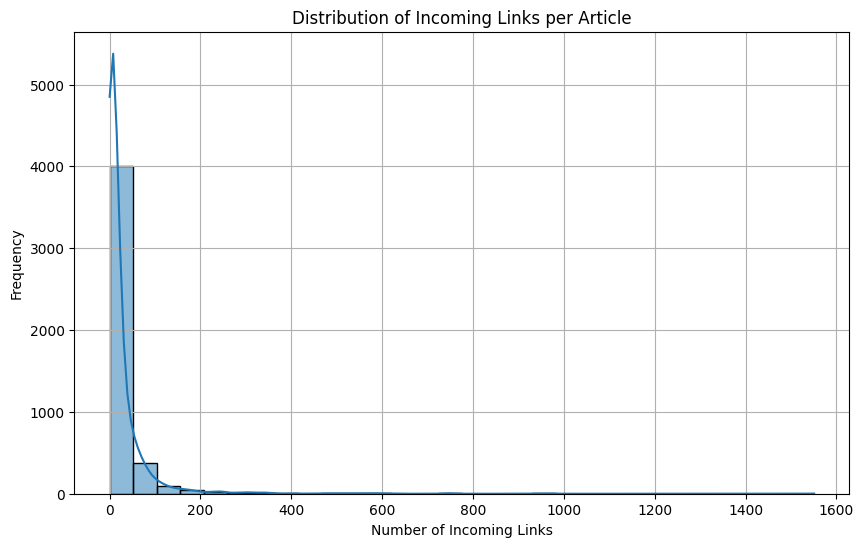

/Users/fletchercollis/opt/anaconda3/envs/CS-401_ADA/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


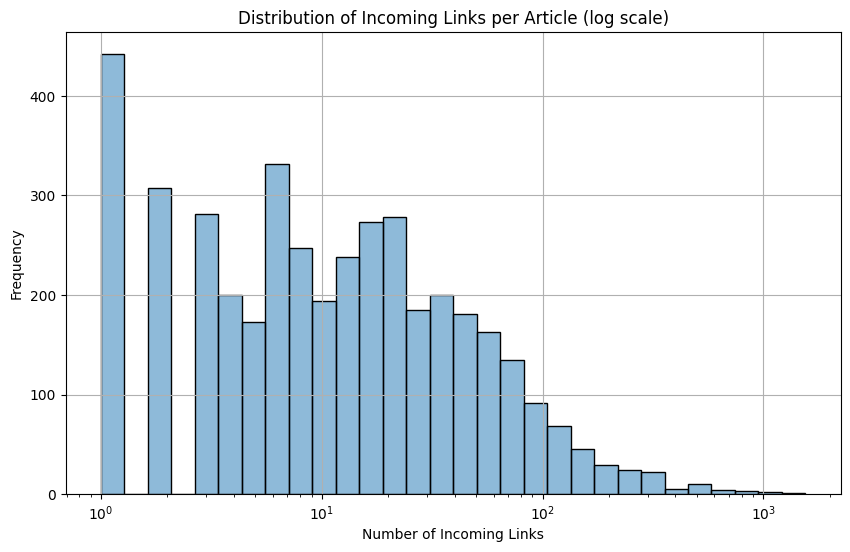

In [30]:
all_incoming_links = article_df['linkTarget'].explode()

incoming_link_counts = all_incoming_links.value_counts()

# Add the incoming link counts as a column in the DataFrame
# Initialize the column with 0 for all articles
article_df['incoming_links'] = article_df['article'].map(incoming_link_counts).fillna(0).astype(int)

print("Summary statistics for incoming links:")
print(incoming_link_counts.describe())

plt.figure(figsize=(10, 6))
sns.histplot(article_df['incoming_links'], bins=30, kde=True)
plt.title("Distribution of Incoming Links per Article")
plt.xlabel("Number of Incoming Links")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the distribution of incoming links log scale for better visualization of the results
plt.figure(figsize=(10, 6))
sns.histplot(article_df['incoming_links'], bins=30, kde=True, log_scale=(True, False))
plt.title("Distribution of Incoming Links per Article (log scale)")
plt.xlabel("Number of Incoming Links")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


**Comment:** The distribution indicates that a small number of articles have a disproportionately large number of incoming links. compared to the rest of the network, these are the cenral hubs of the network ( e.g. United states article). With this heavy tail distribution we might think that it would be a good idea to filter out the outliers but in a systems like Wikispeedia (or any network), the heavy-tailed nature of link distributions is expected. Popular or highly connected articles likely play a central role in efficient navigation and removing any part of the distribution would skew our analysis and lead to biased results.



### Outgoing hyperlinks

Here, we focus on the attribute "outgoing hyperlinks", which represents how an article connects to other articles in the network through one-way hyperlinks.

First, we look at the 10 articles with the most outgoing hyperlinks :


Top 10 Articles with the Most Hyperlinks:
                                        article  num_hyperlinks
4297                              United_States             294
1247               Driving_on_the_left_or_right             255
2504                          List_of_countries             244
2503             List_of_circulating_currencies             236
2515                   List_of_sovereign_states             216
128                                      Africa             212
2505  List_of_countries_by_system_of_government             207
2433                                    Lebanon             192
2134                                   Interpol             191
340                                     Armenia             186


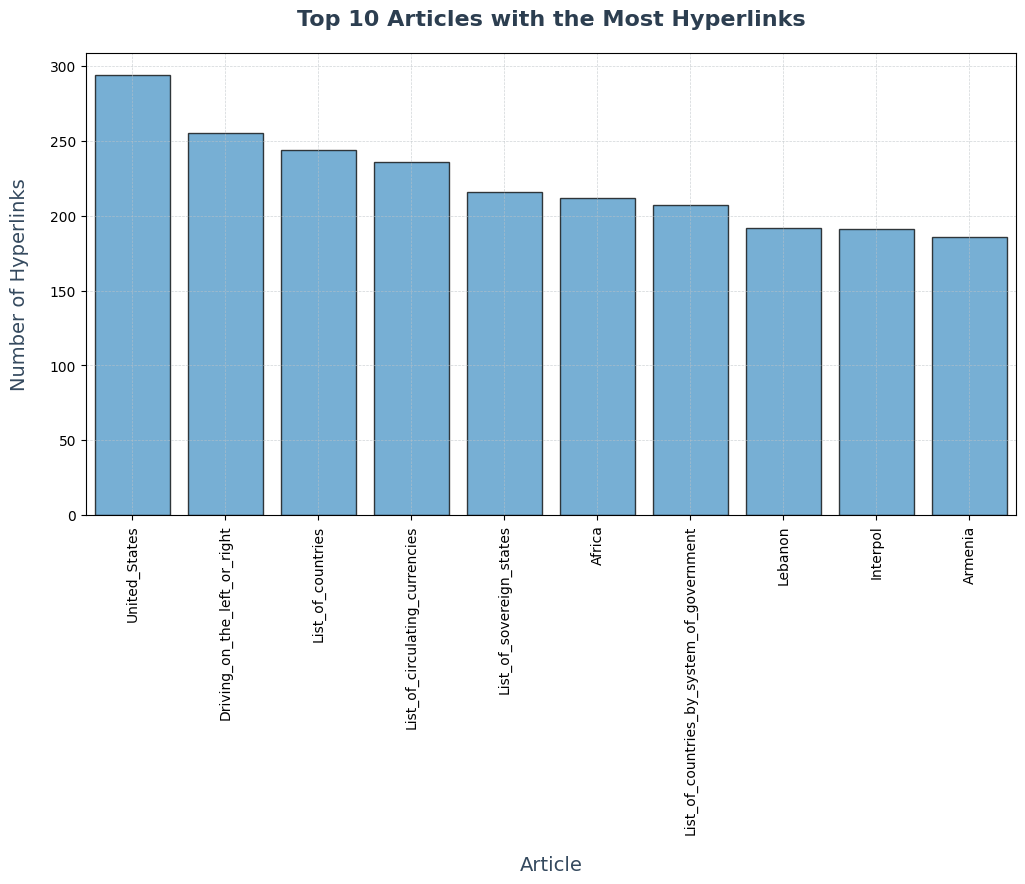

In [43]:
# Clean linkTarget column to replace the Nans by empty lists
article_df['linkTarget'] = article_df['linkTarget'].apply(
    lambda x: list(x) if isinstance(x, (list, np.ndarray)) else []
)

# Add a column with the number of hyperlinks in the article
article_df['num_hyperlinks'] = article_df['linkTarget'].apply(len)


top_hyperlinks = article_df.nlargest(10, 'num_hyperlinks')[['article', 'num_hyperlinks']]
print("\nTop 10 Articles with the Most Hyperlinks:")
print(top_hyperlinks)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_hyperlinks['article'], y=top_hyperlinks['num_hyperlinks'], ax=ax, color='#3498db', edgecolor='black', alpha=0.75)

ax.set_title("Top 10 Articles with the Most Hyperlinks", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Article", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Number of Hyperlinks", fontsize=14, color='#34495E', labelpad=15)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
ax.tick_params(axis='x', rotation=90)

plt.show()

**Comment:** It’s interesting to see that the "United States" article is the most important node in our network. This article consistently ranks highly across different measures. It often appears in the shortest paths between articles and is a common stop in players’ successful games. Because of this, it’s not surprising that it also has the highest number of both incoming and outgoing hyperlinks. We can also notice that some articles, like "List_of_countries," are mostly collections of hyperlinks. These types of articles act as hubs or directories with lots of outgoing hyperlinks, which is why they stand out when looking at hyperlink numbers. 

Now we can look at the distribution of the number of incoming hyperlinks :

Summary statistics for outgoing links:
count    4604.000000
mean       26.038662
std        24.201491
min         0.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
Name: num_hyperlinks, dtype: float64


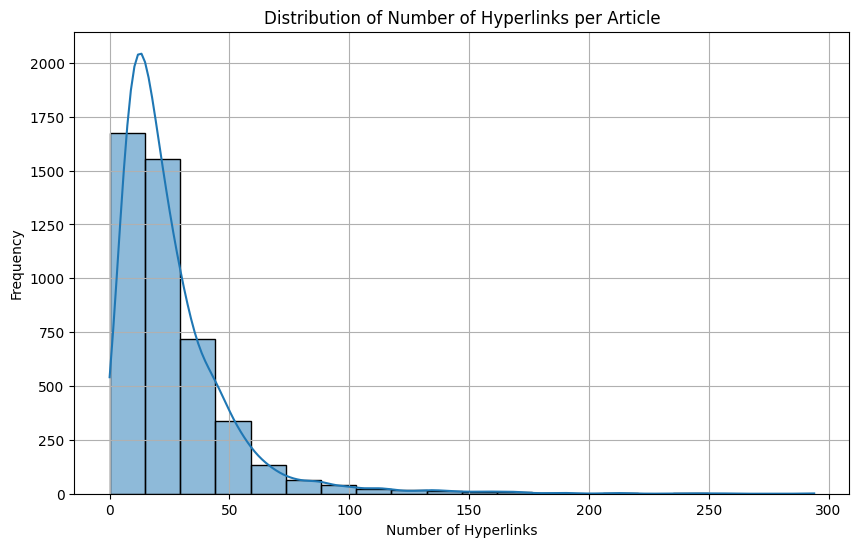

/Users/fletchercollis/opt/anaconda3/envs/CS-401_ADA/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


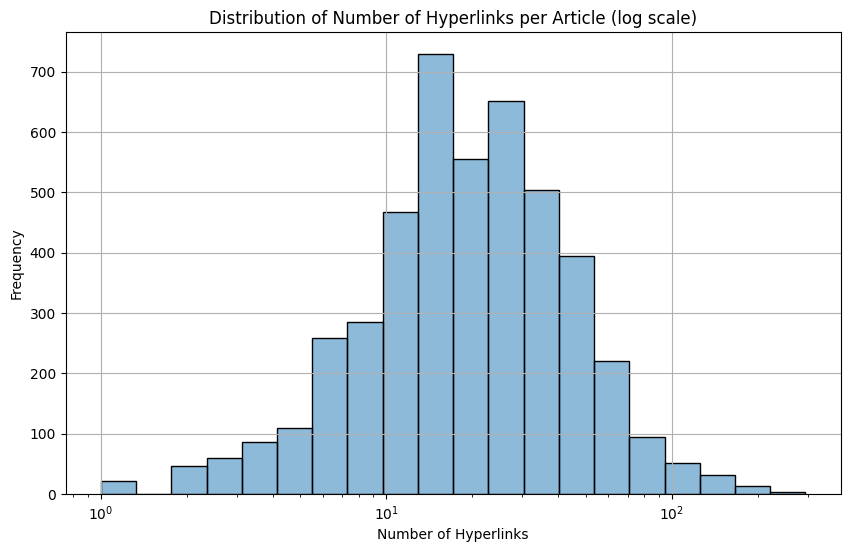

In [32]:
print("Summary statistics for outgoing links:")
print(article_df['num_hyperlinks'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(article_df['num_hyperlinks'], bins=20, kde=True)
plt.title("Distribution of Number of Hyperlinks per Article")
plt.xlabel("Number of Hyperlinks")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the distribution of the number of hyperlinks log scale for better visualisation
plt.figure(figsize=(10, 6))
sns.histplot(article_df['num_hyperlinks'], bins=20, kde=True, log_scale=(True, False) )
plt.title("Distribution of Number of Hyperlinks per Article (log scale)")
plt.xlabel("Number of Hyperlinks")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Comment:** The summary statistics and the above distribution reveal that the number of outgoing links varies widely across articles. Most articles have between 11 and 33 outgoing links. However, the mean of 26 and the standard deviation (24.2) indicate that some articles have significantly more links, as highlighted by the maximum of 294, again highlighting disproportionnality of number of links per article. 

### Hyperlink density

Here, we now focus on the attribute "hyperlink density", which combines the length of an article with the number of outgoing hyperlinks it pocesses.

First, we look at the 10 articles with the highest hyperlink density :


Top 10 Articles by Hyperlink Density:
                                                article  hyperlink_density
2493                         List_of_European_countries           0.025199
2488                          List_of_African_countries           0.024315
2490                            List_of_Asian_countries           0.023562
2496                         List_of_Oceanian_countries           0.022334
2495                   List_of_North_American_countries           0.019239
2134                                           Interpol           0.017781
3020                                   Northwest_Africa           0.017121
2505          List_of_countries_by_system_of_government           0.016477
2509  List_of_members_of_the_Commonwealth_of_Nations...           0.013772
2503                     List_of_circulating_currencies           0.012900


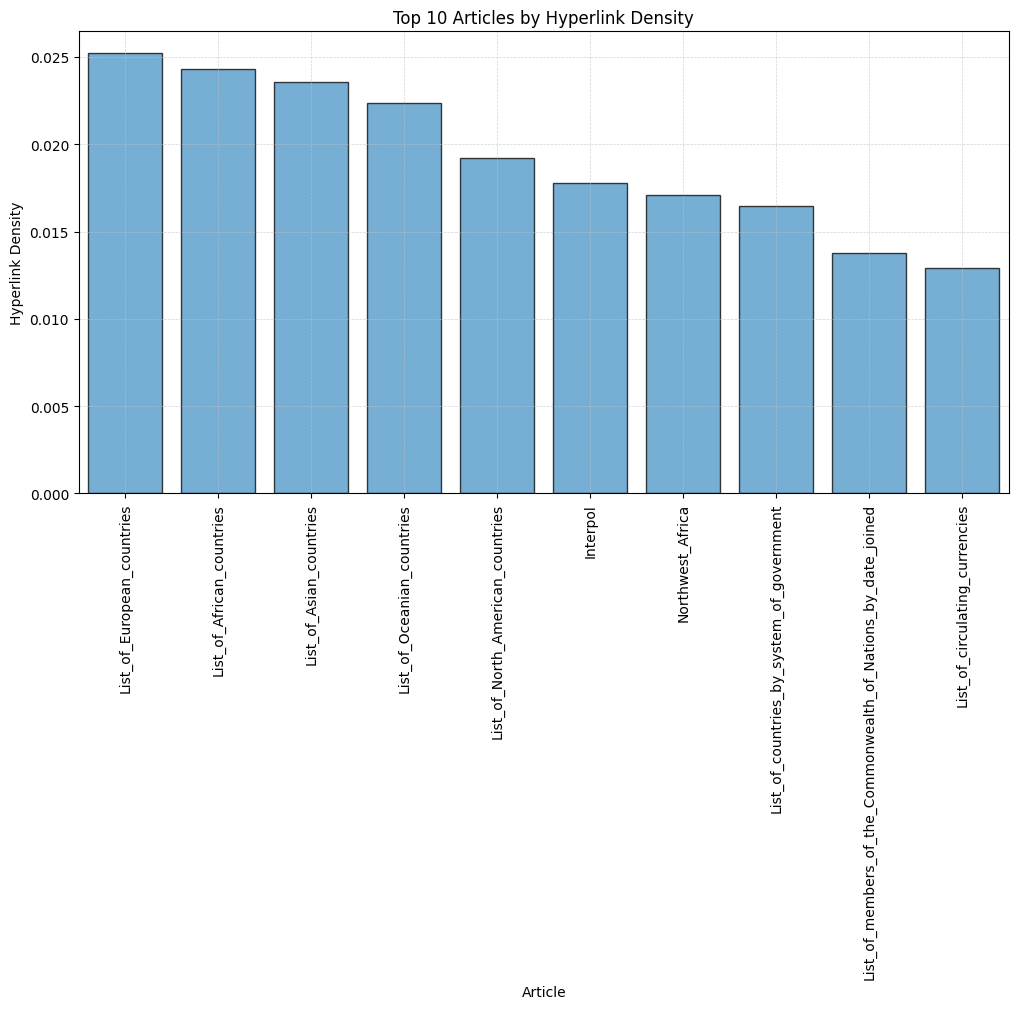

In [44]:
# Ensure plain_text is a string and handle missing values
article_df['plain_text'] = article_df['plain_text'].fillna("").astype(str)

# Calculate the number of characters in the plain_text column
article_df['num_characters'] = article_df['plain_text'].apply(len)

# Calculate hyperlink density (num_hyperlinks / num_characters)
# Avoid division by zero by setting density to 0 if num_characters is 0
article_df['hyperlink_density'] = article_df.apply(
    lambda row: row['num_hyperlinks'] / row['num_characters'] if row['num_characters'] > 0 else 0,
    axis=1
)

# Identify articles with the highest hyperlink density
top_hyperlink_density = article_df.sort_values(by='hyperlink_density', ascending=False).head(10)
print("\nTop 10 Articles by Hyperlink Density:")
print(top_hyperlink_density[['article', 'hyperlink_density']])


plt.figure(figsize=(12, 6))
sns.barplot(x=top_hyperlink_density['article'], y=top_hyperlink_density['hyperlink_density'], color='#3498db', edgecolor='black', alpha=0.75)
plt.xticks(rotation=90)
plt.title("Top 10 Articles by Hyperlink Density")
plt.xlabel("Article")
plt.ylabel("Hyperlink Density")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
plt.show()

**Comment:** We can see that all the articles with the highest hyperlink density are "List" articles. This makes sense, as these articles contain very little text, and nearly every item in the list is a hyperlink to another article. However, this suggests that hyperlink density might not be a reliable indicator of an article’s quality for efficient navigation.


Now we can look at the distribution of hyperlink density :

Summary statistics for hyperlink density:
count    4604.000000
mean        0.001604
std         0.001573
min         0.000000
25%         0.000727
50%         0.001208
75%         0.001953
max         0.025199
Name: hyperlink_density, dtype: float64


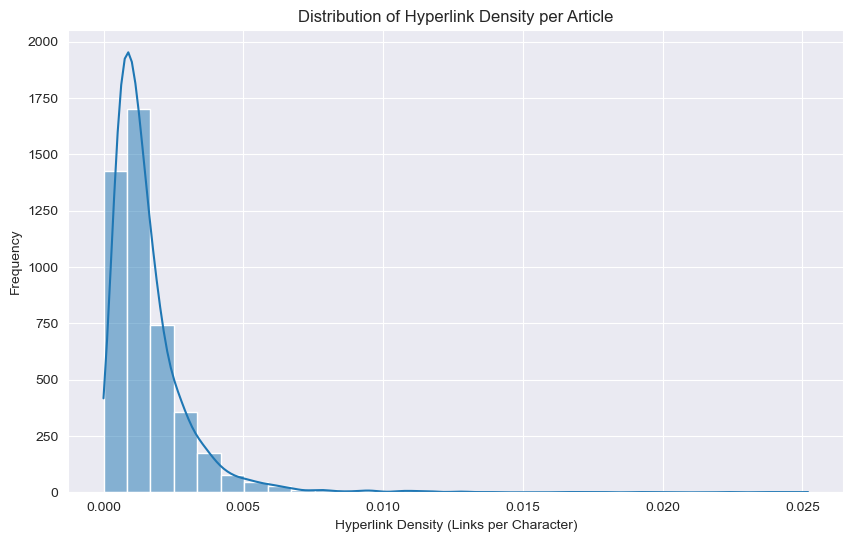

/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


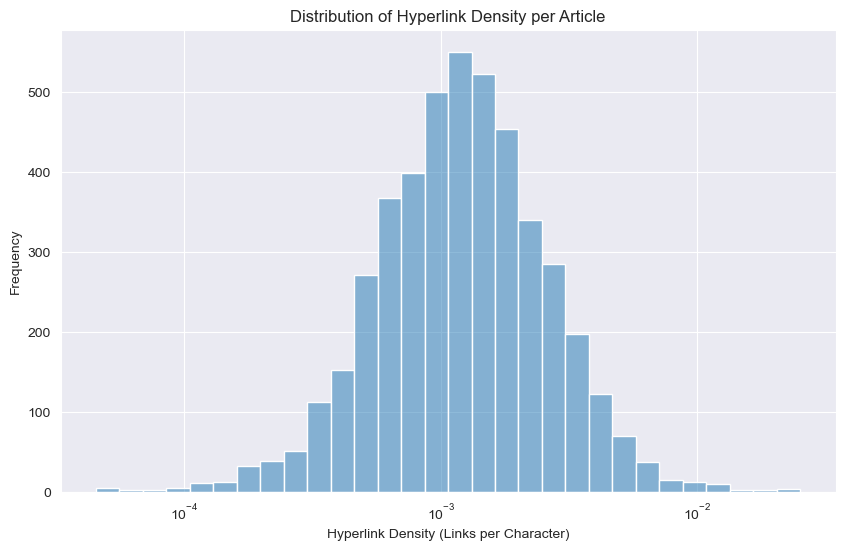

In [34]:
# Summary statistics of hyperlink density
print("Summary statistics for hyperlink density:")
print(article_df['hyperlink_density'].describe())

# Plot the distribution of hyperlink density
plt.figure(figsize=(10, 6))
sns.histplot(article_df['hyperlink_density'], bins=30, kde=True)
plt.title("Distribution of Hyperlink Density per Article")
plt.xlabel("Hyperlink Density (Links per Character)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the distribution of hyperlink density log scale
plt.figure(figsize=(10, 6))
sns.histplot(article_df['hyperlink_density'], bins=30, kde=True, log_scale=(True, False) )
plt.title("Distribution of Hyperlink Density per Article")
plt.xlabel("Hyperlink Density (Links per Character)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Comment:** Here we can see the hyperlink density in the graph follows again a log normal distribution which could again be expected in a network

### Number of characters

Finally, we focus on the attribute "number of characters", which is an indication of the length of each article.


Top 10 Articles by Number of Characters:
                 article  num_characters
734     Byzantine_Empire          108718
4542        World_War_II          101666
4066       The_Holocaust          100238
1453       Extinct_birds           94934
2108  Indo-Greek_Kingdom           91676
2445        Leon_Trotsky           91306
4363         Vietnam_War           90550
1821               Guqin           87886
1369       Elvis_Presley           87815
1012    Condoleezza_Rice           85726


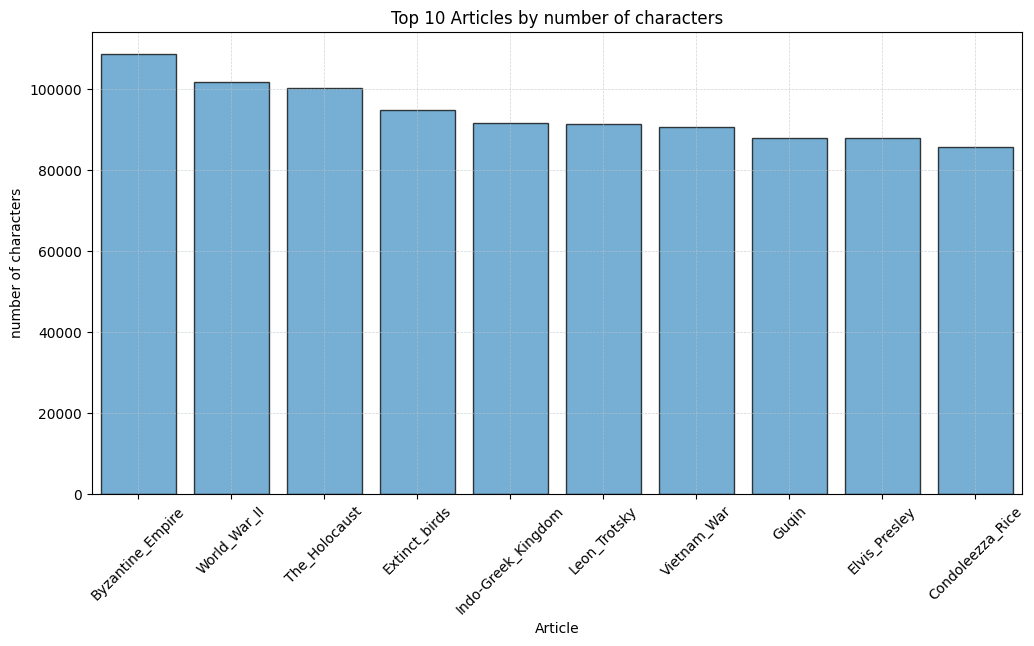

In [36]:
top_characters = article_df.sort_values(by='num_characters', ascending=False).head(10)
print("\nTop 10 Articles by Number of Characters:")
print(top_characters[['article', 'num_characters']])

plt.figure(figsize=(12, 6))
sns.barplot(x=top_characters['article'], y=top_characters['num_characters'], color='#3498db', edgecolor='black', alpha=0.75)
plt.xticks(rotation=45)
plt.title("Top 10 Articles by number of characters")
plt.xlabel("Article")
plt.ylabel("number of characters")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
plt.show()

**Comment:** The top 10 articles with the highest letter count are dominated by historical events, likely because these events are long, well-documented, and contain a lot of information. In addition to historical events, three of the articles are biographical, indicating that articles about people can also have a high letter count which could be due to the detailed nature of their life histories leading to long articles.


Summary statistics for number of characters:
count      4604.000000
mean      21232.968723
std       15508.639317
min         828.000000
25%        8811.750000
50%       17736.500000
75%       30104.750000
max      108718.000000
Name: num_characters, dtype: float64


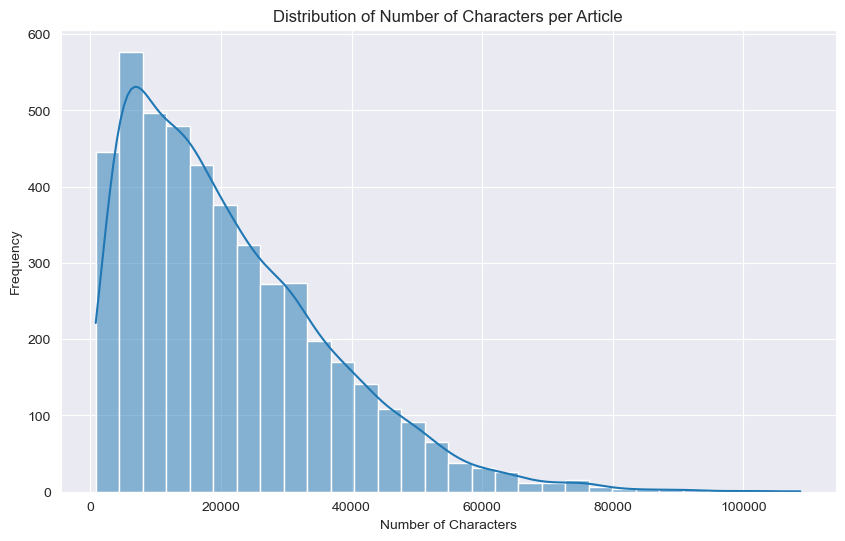

In [36]:
print("\nSummary statistics for number of characters:")
print(article_df['num_characters'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(article_df['num_characters'], bins=30, kde=True)
plt.title("Distribution of Number of Characters per Article")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Comment:** Most articles range between 8'000 and 30'000 characters, with a slight right skew due to a few very long articles, indicating considerable variation in article lengths.

## Exploration of semantic distances between articles

### Semantic Similarity

We can compute basic semantic distance on articles simply by creating embeddings for the titles of the articles. In P3, we can expand this to calculate embeddings using full article text. 

### Computing the Embeddings

First, let's compute the embeddings. We can follow a HuggingFace tutorial on generating text embeddings. This tutorial is found [here](https://huggingface.co/blog/getting-started-with-embeddings). For each title, we will generate an embedding, and store it in our dataframe.

In [37]:
article_names = articles['article']

# Here fetch a token from hugging face website
# https://huggingface.co/blog/getting-started-with-embeddings
model_id = "sentence-transformers/all-MiniLM-L6-v2"
hf_token = "insert token here"

api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"
headers = {"Authorization": f"Bearer {hf_token}"}

In [38]:
def query(texts):
    response = requests.post(api_url, headers=headers, json={"inputs": texts, "options":{"wait_for_model":True}})
    return response.json()

article_names_list = article_names.tolist()

#replace _ with space in article names
article_names_list = [name.replace("_", " ") for name in article_names_list]

output = query(article_names_list)

articles['embeddings'] = output

articles.to_feather('Data/dataframes/article_dataframe_with_embeddings.feather')

### Analyzing the Embeddings

There are lots of tools to visualize and analyze embeddings. In order to extract meaningful representations, a common tactic is to reduce the dimensionality of the embeddings. The two main tools for this are PCA and T-SNE. 
See [here](https://distill.pub/2016/misread-tsne/) for a great overview on T-SNE.
We can use both of these via scikit-learn. For now, we just want to get a feel for the data. Let's use tensorflow's Embedding Projector tool. This tool can be hosted locally or used in a browser. 

#### Embedding Projector

Embedding Projector is a useful tool made by TF to look at word embedding spaces. Let's save our data so it can be opened there.

https://projector.tensorflow.org/

Note that the embedding projector can also be used locally.

In [39]:
# Here uncomment the code oônce a token is used to see our results

# Separate embeddings as a new DataFrame
#embeddings_df = pd.DataFrame(articles['embeddings'].tolist())

# Save embeddings to TSV
#embeddings_df.to_csv('Data/embeddings/embeddings.tsv', sep='\t', header=False, index=False)

# Save metadata to TSV
#metadata_df = articles[['article']]
#metadata_df.to_csv('metadata.tsv', sep='\t', header=False, index=False)

#articles[articles['article'] == 'Code_of_Hammurabi']

In [40]:
# Taken from OpenAI's tutorial on embeddings

#matrix = np.array(articles['embeddings'].tolist())

# Create a t-SNE model and transform the data
#tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
#vis_dims = tsne.fit_transform(matrix)

#colors = ["red", "darkorange", "gold", "turquiose", "darkgreen"]
#x = [x for x,y in vis_dims]
#y = [y for x,y in vis_dims]
# color_indices = df.Score.values - 1

#colormap = matplotlib.colors.ListedColormap(colors)
#plt.scatter(x, y, cmap=colormap, alpha=0.3)
#plt.title("Article Names visualized using t-SNE")

### TF's Embedding Projector

After saving our embeddings and their required metadata according to EmbeddingProjector's specifications, we can load the data into the tool. For now, let's use T-SNE in order to group the data. Here is what the data looks like after 1000 iterations of T-SNE:

![Default projections](Figures/default_1000_tsne.png)

But . . . does it even work? Well, let's do a gut check. What is that clump of titles at the top?

![Tropical Storms](Figures/tropical_storms.png)

Interesting! It seems like tropical storms are on a level of their own! That is, they share semantic meaning with each other but not other titles.Let's look at some common according to our statistics. For example, what is close to the United States?

![US TSNE](Figures/UnitedStates_TSNE.png)

We can also see what is close to the `United_States` title in the original, unprojected space. Cosine and Euclidean distance are both easily implementable in python, and already exist in multiple packages like scikit-learn.

![US Nearest](Figures/US_Nearest.png)

This Euclidean/Cosine distance will serve as our metric for semantic distance.

**END OF PREPROCESSING & exploratory data analysis**

# Part 2 : graph theory based top articles

**Comment:** In this analysis, we have divided the count by the total number of shortest paths for each source-target pair. This normalization helps us measure the true importance of each article in the network. Without normalization, an article that appears in every shortest path for a specific source-target pair might seem highly important, even if it doesn’t play a critical role across the entire network. By normalizing, we avoid overemphasizing articles that are only crucial within specific source-target pairs and ensure that the count more accurately reflects an article’s overall significance in the network.

$$
\text{Article k's Importance in (i ; j)} = \frac{A_{k}^{(i,j)}}{P^{(i,j)}}
$$

where:

$$
\begin{aligned}
A_{k}^{(i,j)} &= \text{Number of times article } k \text{ appears in shortest paths between source } i \text{ and target } j, \\
P^{(i,j)} &= \text{Total number of shortest paths between } i \text{ and } j.
\end{aligned}
$$



In [41]:

paths_finished['finished'] = True
paths_finished['failure_reason'] = None

paths_finished['start_article'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
paths_finished['target_article'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])


paths_unfinished['finished'] = False

paths_unfinished.rename(columns={'type': 'failure_reason', 'target' : 'target_article'}, inplace=True)

paths_unfinished['start_article'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0])

paths = pd.concat([paths_finished, paths_unfinished])

finished_paths = paths[paths['finished'] == True]

unique_pairs = finished_paths[['start_article', 'target_article']].drop_duplicates()

pair_counts = finished_paths.groupby(['start_article', 'target_article']).size().reset_index(name='count')

#pair_counts

**Comment:** We also decided to concentrate our analysis on source-target pairs that are actually used in the game. By focusing only on these pairs, we generate a final list of articles that are theoretically advantageous for all possible gameplay scenarios. This approach prevents the inclusion of articles that may appear to be effective in connecting pairs not relevant to the game, which could otherwise skew the analysis.

In [42]:
from collections import defaultdict

node_counts = defaultdict(int)

errors = 0

all_nb_of_shortest_paths = []

for _, row in pair_counts.iterrows():
    source = row['start_article']
    target = row['target_article']

    try:

        all_paths = list(nx.all_shortest_paths(G, source=source, target=target))

        nb_of_shortest_paths = len(all_paths)

        all_nb_of_shortest_paths.append(nb_of_shortest_paths)
        
        for path in all_paths:
            for node in path:
                if node != source and node != target:
                    node_counts[node] += 1/nb_of_shortest_paths

    except nx.NetworkXNoPath:
        # Skip this source-target pair if no path exists
        errors +=1


node_counts_df = pd.DataFrame(node_counts.items(), columns=['Node', 'ShortestPathCount'])

### Results

In [43]:
# Sort by the 'ShortestPathCount' column in ascending order
node_counts_df = node_counts_df.sort_values(by='ShortestPathCount', ascending=False)
node_counts_df.head(20)

,Node,ShortestPathCount
27,United_States,2778.997827
124,United_Kingdom,1128.250118
77,Europe,809.943234
79,England,746.721314
174,Africa,716.774062
2,Germany,614.765519
92,World_War_II,534.374375
230,Japan,526.817727
143,Earth,480.186276
1,France,417.042087


**Comment:** Here, we display the first 20 articles identified as most important across the network. These articles are ranked based on their normalized shortest path count, highlighting those that play a critical role in connecting various parts of the network. We can notice that topics related to influential countries (like the United States and the United Kingdom), broad regions (such as Europe and Africa), and significant historical events (like World War II) are among the highest-ranked. This suggests that geopolitical, regional, and historical themes are central to the network's structure, serving as key connectors across diverse topics.

In [44]:
node_counts_df['ShortestPathCount'].describe()

count    3735.000000
mean       13.928782
std        63.764178
min         0.003125
25%         0.506233
50%         2.513890
75%         9.294983
max      2778.997827
Name: ShortestPathCount, dtype: float64

**Comment:** 
- *Count :* Here, we see that 3'735 out of 4'604 articles are active nodes in the games network, representing about 81% of the total. This suggests that the majority of articles contribute to the games network's connectivity, while the remaining 19% may be more isolated or peripheral.
- *Mean :* The mean suggests most articles are not very important based on our metric. The quantiles support this, with the 25th and 50th percentiles showing that most articles appear in only a few shortest paths. A small number of articles are highly central, indicating a long-tailed distribution where a few nodes dominate the network.

## Part 3 : game based top articles

We will try to quantify what articles are the most important in user navigation using various approaches from simple to more complex
### Naive approach

First we just look at articles than come up the most in the filtered data. This is of course a very naive approach and will just serve as comparison for the subsequent ones.

In [45]:
# 1. naive approach described above.
# will use the simplied paths (direct paths) as contrary to full path more apperances necessary imply importance

simplified_paths = filtered_paths['simplified_path'].copy()

simplified_paths.apply(lambda l: l[1:-1]) # drop start and target article

article_count = pd.Series(dtype=int)

# Loop through each path and count each article
for path in simplified_paths:
    for article in path:
        article_count[article] = article_count.get(article, 0) + 1

# order 
article_count = article_count.sort_values(ascending=False)

article_count.head(10)

United_States     9745
Europe            4581
United_Kingdom    4148
England           3495
Earth             3418
Africa            2976
World_War_II      2382
North_America     1960
Germany           1793
Human             1727
dtype: int64

### Weighted Average of All Articles

This allows for averaging without being overly influenced by differences between the start and target pairs. We will define weight as: 
$$
\text{Weight} = 1 - \frac{\text{Actual Path Length} - \text{Optimal Distance}}{\text{Actual Path Length}} = \frac{\text{Optimal Path Length}}{\text{Actual Path Length}}
$$
This weight captures how much the actual path deviates from the optimal distance as a ratio of the actual path length.

The weighted average will allow us to evaluate the average quality of an article's appearances.

Note: I don't consider the start and target articles, in the paths, maybe keep targets ?

In [46]:
# we can only use finished paths for this analysis.
# use simplified path lengths for diff calculation

# 1. make new df where a weight is assigned to each path (both described above), and a col for simplified and full path
# 2. A function that takes this df and iterates through the simplified path column, where it checks what articles appear in it
#    and adds that weight that row to a total weight sum of an other data frame. This other data frame should consist of the following rows:
#    |article_name|n_counts|weighted_avg|normalized_path_score_avg|

# 1.
df = filtered_finished_paths[['simplified_path', 'simplified_path_length', 'distance']].copy()

# again drop start and end articles
df['simplified_path'] = df['simplified_path'].apply(lambda l: l[1:-1])

# Calc weight and add to df
df['weight'] = df['distance'] / df['simplified_path_length']

df.head()


,simplified_path,simplified_path_length,distance,weight
0,"[15th_century, 16th_century, Pacific_Ocean, At...",8,3.0,0.375000
1,"[Europe, Africa, Atlantic_slave_trade]",4,3.0,0.750000
2,"[Niger, Nigeria, British_Empire, Slavery, Afri...",7,3.0,0.428571
3,"[Renaissance, Ancient_Greece]",3,2.0,0.666667
4,"[Italy, Roman_Catholic_Church, HIV, Ronald_Rea...",6,3.0,0.500000


In [47]:
# 2. Create an empty DataFrame for aggregating article results 
avg_article_weight_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_avg'])
avg_article_weight_df.set_index('article', inplace=True)

for index, row in df.iterrows():
    weight = row['weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        # Iterate through articles in the simplified path
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in avg_article_weight_df.index:
                # If the article is not in the DataFrame, initialize a new row
                avg_article_weight_df.loc[article] = [0, 0]

            # Update counts and weighted sums
            avg_article_weight_df.at[article, 'n_appearances'] += 1
            avg_article_weight_df.at[article, 'weighted_avg'] += weight

# Calculate the weighted average by dividing by the counts
avg_article_weight_df['weighted_avg'] = avg_article_weight_df['weighted_avg'] / avg_article_weight_df['n_appearances']

/var/folders/80/hqwr4qh5045_gwp_l1039pdw0000gn/T/ipykernel_69159/1704071625.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_article_weight_df.at[article, 'weighted_avg'] += weight


In [48]:
avg_article_weight_df = avg_article_weight_df.sort_values(by='weighted_avg', ascending=False)
avg_article_weight_df

,n_appearances,weighted_avg
article,,
Zheng_He,1,1.00
International_Red_Cross_and_Red_Crescent_Movement,1,1.00
Badminton,1,1.00
H5N1,1,1.00
Antimony,1,1.00
...,...,...
Gallium,1,0.25
Akkadian_Empire,1,0.25
Wild_cat,1,0.25


Articles that only show up once in the whole paths considered are not assigned a meaningfull weight value. We need to filter again. Whe can for example only consider articles that at least appear 30 times. This would still leave us with a fairly large data set that we can use for further analysis.

In [49]:
filtered_weighted_avg_df = avg_article_weight_df[avg_article_weight_df['n_appearances'] >= 30]
filtered_weighted_avg_df

,n_appearances,weighted_avg
article,,
Extrasolar_planet,48,0.727364
Black_Sea,53,0.666584
Whale_shark,272,0.651068
Information,321,0.649007
International_law,31,0.643510
...,...,...
Bible,46,0.449474
Radio,85,0.449402
Athens,66,0.448088


### Weighted Sum of sampled articles

In this case, instead of taking the average of the weight per article we sum the wieghts over all articles. This metric will of course be larger for articles that appear more often. Thus, it will be less informative about article quality, but likely more meaningfull in showing what articles are the most usefull for players overall. 
To adjust for the imbalance in start-target pairs, we need to downsample the data to only 1 sample per pair. As we saw that over 50% of the data only has one such sample already, this should not result in a to large chunck of removed samples.

In [50]:
# first downsample the df so that there only is one sample per start-target pair.

# Set the random seed for reproducibility
np.random.seed(42)

shuffled_df = filtered_finished_paths.sample(frac=1).reset_index(drop=True)
filtered_paths_sampled = shuffled_df.drop_duplicates(subset='identifier', keep='first').reset_index(drop=True)

# Calculate the number of removed rows
removed = filtered_finished_paths.shape[0] - filtered_paths_sampled.shape[0]

# Print the result
print(f"In sampling a total of {removed} samples were removed, "
      f"which represents {removed / filtered_finished_paths.shape[0] * 100:.3f}% of the original data.",
      f"{filtered_paths_sampled.shape[0]} samples remain.")

In sampling a total of 20010 samples were removed, which represents 41.965% of the original data. 27673 samples remain.


In [51]:
# very similar code as for weighted average overall
df2 = filtered_paths_sampled[['simplified_path', 'simplified_path_length', 'distance']].copy()

# Calc weight and add to df
df2['weight'] = df2['distance'] / df2['simplified_path_length']

article_weightes_sum_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_sum'])
article_weightes_sum_df.set_index('article', inplace=True)

for index, row in df2.iterrows():
    weight = row['weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        # Iterate through articles in the simplified path
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in article_weightes_sum_df.index:
                # If the article is not in the DataFrame, initialize a new row
                article_weightes_sum_df.loc[article] = [0, 0]

            # Update counts and weighted sums
            article_weightes_sum_df.at[article, 'n_appearances'] += 1
            article_weightes_sum_df.at[article, 'weighted_sum'] += weight

/var/folders/80/hqwr4qh5045_gwp_l1039pdw0000gn/T/ipykernel_69159/1887511229.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  article_weightes_sum_df.at[article, 'weighted_sum'] += weight


In [52]:
article_weightes_sum_df = article_weightes_sum_df.sort_values(by='weighted_sum', ascending=False)

article_weightes_sum_df.head(10)

,n_appearances,weighted_sum
article,,
United_States,4534,3205.278499
Europe,2168,1423.762302
United_Kingdom,2113,1401.557143
England,1660,1083.717027
Africa,1364,930.151768
Earth,1187,763.651587
World_War_II,1104,757.799206
France,837,557.654762
Germany,811,556.206349


**Comment** 

This is not really a surprise, the articles that show up the most often also have the highest weighted_sum. Does that necessarily make them the best articles for efficient users to navigation? This is hard to tell as they are obviously different from highest 'quality' articles we extracted above.


Alternatively, we can center the weights around 0 before computing the weighted sum to reduce the bias introduced by the number of appearances of articles. This way, articles with more appearances won't necessarily lead to a disproportionately large weighted sum score. This can help highlight articles that are truly impactful relative to the average. 
To do so we use the follwoing formulas:

$$
\text{article\_mean\_weight} = \frac{\sum (\text{weight} \times \text{simplified\_path\_length})}{\sum (\text{simplified\_path\_length})}
$$

$$
\text{centered\_weight} = \text{weight} - \text{article\_mean\_weight}
$$

$$
\text{article\_weighted\_sum} = \sum \left( \text{centered\_weight} \times \text{n\_appearances} \right)
$$

In [53]:
# Calculate mean weight
article_mean_weight = (df2['weight'] * df2['simplified_path_length']).sum() / df2['simplified_path_length'].sum()

# Center the weights by subtracting the mean
df2['centered_weight'] = df2['weight'] - article_mean_weight

article_weightes_sum_df2 = pd.DataFrame(columns=['article_name', 'n_appearances', 'weighted_sum'])
article_weightes_sum_df2.set_index('article_name', inplace=True)

for index, row in df2.iterrows():
    centered_weight = row['centered_weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in article_weightes_sum_df2.index:
                article_weightes_sum_df2.loc[article] = [0, 0]  # Initialize count and sum

            # Update counts and centered weighted sum
            article_weightes_sum_df2.at[article, 'n_appearances'] += 1
            article_weightes_sum_df2.at[article, 'weighted_sum'] += centered_weight


/var/folders/80/hqwr4qh5045_gwp_l1039pdw0000gn/T/ipykernel_69159/1393077498.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09830571274589062' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  article_weightes_sum_df2.at[article, 'weighted_sum'] += centered_weight


In [54]:
article_weightes_sum_df2 = article_weightes_sum_df2.sort_values(by='weighted_sum', ascending=False)

article_weightes_sum_df2


,n_appearances,weighted_sum
article_name,,
United_States,4534,250.496601
Africa,1364,41.240760
World_War_II,1104,38.328713
Japan,484,28.509294
Germany,811,27.682282
...,...,...
Great_Britain,297,-23.702013
European_Union,431,-24.659206
Continent,305,-28.221520


Things have definetly changed let's compare the top scoring articles of the centered weighted sum vs weighted sum and the average weighted average.

In [55]:
# Again the articles that appear only few times should not be considered
article_weightes_sum_df2 = article_weightes_sum_df2[article_weightes_sum_df2['n_appearances'] >= 30]
article_weightes_sum_df2

,n_appearances,weighted_sum
article_name,,
United_States,4534,250.496601
Africa,1364,41.240760
World_War_II,1104,38.328713
Japan,484,28.509294
Germany,811,27.682282
...,...,...
Great_Britain,297,-23.702013
European_Union,431,-24.659206
Continent,305,-28.221520


**Comment**

It is obvious that in this apporach articles that appear much more often will also have the most extreme weight values. But this might be a decent compromise between article 'quality' and article 'usefulness' for players.

**Comparison** of the methods

In [56]:
top_n = 10

# Top articles
print(f"Top {top_n} articles for the Weighted Average Approach and their corresponding weights:")
print(filtered_weighted_avg_df.head(top_n))

print(f"\nTop {top_n} articles for the Standard Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df.head(top_n))

print(f"\nTop {top_n} articles for the Centered Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df2.head(top_n))

Top 10 articles for the Weighted Average Approach and their corresponding weights:
                             n_appearances  weighted_avg
article                                                 
Extrasolar_planet                       48      0.727364
Black_Sea                               53      0.666584
Whale_shark                            272      0.651068
Information                            321      0.649007
International_law                       31      0.643510
Tennis                                  46      0.637535
Aluminium                               39      0.622222
Bird                                   310      0.618967
Cinema_of_the_United_States            100      0.618742
Tropical_cyclone                       135      0.611177

Top 10 articles for the Standard Weighted Sum Approach and their corresponding weights:
                n_appearances  weighted_sum
article                                    
United_States            4534   3205.278499
Europe      

In [57]:
worst_n = 10

# Worst articles
print(f"\nWorst {worst_n} articles for the Weighted Average Approach and their corresponding weights:")
print(filtered_weighted_avg_df.tail(worst_n))

print(f"\nWorst {worst_n} articles for the Standard Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df.tail(worst_n))

print(f"\nWorst {worst_n} articles for the Centered Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df2.tail(worst_n))


Worst 10 articles for the Weighted Average Approach and their corresponding weights:
              n_appearances  weighted_avg
article                                  
Matter                   51      0.455096
History                  46      0.452088
Jesus                    45      0.451235
East_Africa              53      0.450382
Persian_Gulf             32      0.450149
Bible                    46      0.449474
Radio                    85      0.449402
Athens                   66      0.448088
Gardening                38      0.446805
Irrigation               54      0.430467

Worst 10 articles for the Standard Weighted Sum Approach and their corresponding weights:
                   n_appearances  weighted_sum
article                                       
Magpie                         1      0.333333
Guglielmo_Marconi              1      0.285714
Hawk-Eye                       1      0.285714
William_McKinley               1      0.285714
Walter_Raleigh                 1     

### OTHER IDEA working with the pairs where there is a ton of samples

We can also make use of the finding that we have over 1000 samples for certain pairs as this will allow for much more precise article scoring metrics. Thus in a third apporach we use only the top occuring start-target pairs and compute and rank the articles that appear using again the same weighted path length - distance approach but also considering if the unfinished paths, penalizing articles that appear in them...

In [58]:
# only consider the top 4 as they all have size > 1000
n = 4

identifier_grouped = filtered_paths.groupby(['identifier'])

# Sort by group size in descending order and take the top 10 largest groups
top_identifiers = identifier_grouped.size().sort_values(ascending=False).head(n).index

# extract all the paths from the filtered df with these identifiers
top_pairs_df = filtered_paths[filtered_paths['identifier'].isin(top_identifiers)].copy()

top_pairs_df.shape

(4868, 15)

In [59]:
# steps from here 
# - similar metrics as above to get weights
# - can also consider additional metric => ratio nb of times apears article in unfinished over total nb of times article appears...
#   (I could incorporate this metric in the above as well maybe)
# - can do ML / regression to learn coeeficient of these two parameters...


# Part 4 : Analysis of the results found and correlation with attributes

Here we will study the correlation between our article atributes and the ranking metrics that we came up with, but the results we observe must be treated with caution as at the moment the ranking is still quite arbitrary and we will need further analysis to determine which articles can really be considered as good in navigation path.

In [60]:
# This is the next step
article_df

,article,article_unrendered_unicode,category,linkSource,linkTarget,distances,plain_text,incoming_links,num_hyperlinks,num_characters,hyperlink_density
0,Áedán_mac_Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,[subject.History.British_History.British_Histo...,Áedán_mac_Gabráin,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,0,11,11612,0.000947
1,Åland,%C3%85land,"[subject.Countries, subject.Geography.European...",Åland,"[20th_century, Baltic_Sea, Crimean_War, Curren...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÅland\n\n2007 Schools Wikiped...,0,19,17238,0.001102
2,Édouard_Manet,%C3%89douard_Manet,[subject.People.Artists],Édouard_Manet,"[Absinthe, Beer, Claude_Monet, Diego_Velázquez...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉdouard Manet\n\n2007 Schools...,0,20,18996,0.001053
3,Éire,%C3%89ire,"[subject.Countries, subject.Geography.European...",Éire,"[Canada, English_language, George_VI_of_the_Un...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉire\n\n2007 Schools Wikipedi...,0,8,13083,0.000611
4,Óengus_I_of_the_Picts,%C3%93engus_I_of_the_Picts,[subject.History.British_History.British_Histo...,Óengus_I_of_the_Picts,"[Dál_Riata, Durham, England, Great_Britain, Ir...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÓengus I of the Picts\n\n2007...,0,10,12944,0.000773
...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,Zionism,"[subject.People.Political_People, subject.Reli...",Zionism,"[18th_century, 19th_century, Adolf_Hitler, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZionism\n\n2007 Schools Wikip...,25,74,62086,0.001192
4600,Zirconium,Zirconium,[subject.Science.Chemistry.Chemical_elements],Zirconium,"[Aluminium, Arabic_language, Australia, Bicycl...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZirconium\n\n2007 Schools Wik...,15,42,13253,0.003169
4601,Zoroaster,Zoroaster,[subject.People.Religious_figures_and_leaders],Zoroaster,"[18th_century, 9th_century, Afghanistan, Age_o...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZoroaster\n\n2007 Schools Wik...,9,28,19726,0.001419
4602,Zuid-Gelders,Zuid-Gelders,"[subject.Geography.European_Geography, subject...",Zuid-Gelders,"[Brabantian, Dutch_language, East_Flemish, Hol...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZuid-Gelders\n\n2007 Schools ...,5,5,2341,0.002136


In [61]:
article_weightes_sum_df2

,n_appearances,weighted_sum
article_name,,
United_States,4534,250.496601
Africa,1364,41.240760
World_War_II,1104,38.328713
Japan,484,28.509294
Germany,811,27.682282
...,...,...
Great_Britain,297,-23.702013
European_Union,431,-24.659206
Continent,305,-28.221520


In [62]:
# Rename column for alignment
article_weightes_sum_df2 = article_weightes_sum_df2.reset_index()
article_weightes_sum_df2 = article_weightes_sum_df2.rename(columns={'article_name': 'article'})
# Merge the two DataFrames on 'article'
combined_df = pd.merge(article_df, article_weightes_sum_df2, on='article', how='inner')

Correlation between weighted_sum ranking and ranks of each metric:
rank_incoming_links       0.058198
rank_num_hyperlinks       0.189670
rank_num_characters       0.249091
rank_hyperlink_density   -0.044697
dtype: float64


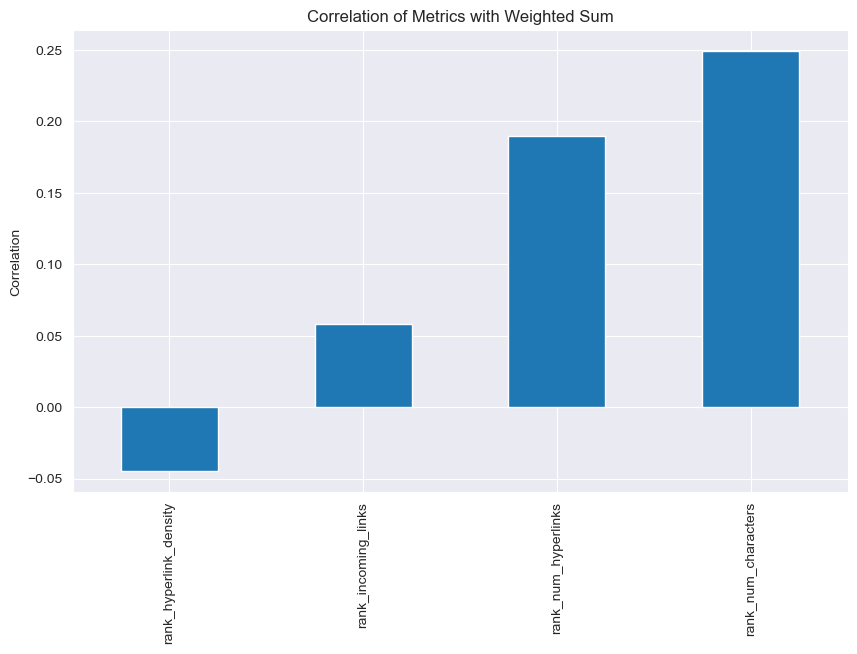

In [63]:
# Rank articles for each metric
combined_df['rank_incoming_links'] = combined_df['incoming_links'].rank(ascending=False)
combined_df['rank_num_hyperlinks'] = combined_df['num_hyperlinks'].rank(ascending=False)
combined_df['rank_num_characters'] = combined_df['num_characters'].rank(ascending=False)
combined_df['rank_hyperlink_density'] = combined_df['hyperlink_density'].rank(ascending=False)
combined_df['rank_weighted_sum'] = combined_df['weighted_sum'].rank(ascending=False)

# Compute correlations between ranks and weighted_sum
correlations = combined_df[
    ['rank_incoming_links', 'rank_num_hyperlinks', 'rank_num_characters', 'rank_hyperlink_density']
].corrwith(combined_df['rank_weighted_sum'])

# Display correlation results
print("Correlation between weighted_sum ranking and ranks of each metric:")
print(correlations)

# Visualize correlations
import matplotlib.pyplot as plt
correlations.sort_values().plot(kind='bar', figsize=(10, 6), title="Correlation of Metrics with Weighted Sum")
plt.ylabel("Correlation")
plt.show()

Interestingly the attribute of article that is the most strongly correlated to the weighted sum ranking of articles is the length of the article, also the hyperlink density is negatively correlated with the weighted sum ranking supposing that having very dense articles might loose the players and lead them to a suboptimal navigation.